In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import ROOT

from root_numpy import root2array,fill_profile
from scipy.stats import norm as StatsNorm       # for gaussian fitting
from scipy.optimize import curve_fit
from ROOT import TProfile
from tqdm import tqdm                           # tqdm ipython built-in progress bar

Welcome to JupyROOT 6.18/02


/scratch/group/mitchcomp/eb/x86_64/sw/root_numpy/4.8.0-foss-2018b-Python-3.6.6/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.19.5 is currently installed but you installed root_numpy against numpy 1.15.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [3]:
#Predefine the figure size and font size
%matplotlib inline
plt.rcParams['figure.figsize'] = [10.7, 6]
plt.rcParams['font.size']=20
plt.rcParams['axes.labelsize']=16
plt.rcParams['axes.titlesize']=20
plt.rcParams['figure.dpi']=80
plt.rcParams['legend.fontsize']=16

# 0. Data File and Quantities

In [213]:
directory = '/scratch/user/kelsey/data/CDMSlite_time/'
# Particle Hits and DMC outputs (combined)
SuperSim_dir = directory
SuperSimfile = sorted(glob.glob(SuperSim_dir+'/*Y0mm*.root'))
# Raw data (combined)
#RawData_dir = directory + '/raw/custom/*may15*/combined_Binary_files'
#RawDatafile = sorted(glob.glob(RawData_dir+'/*.gz'))
# RQ and RRQ
#RQRRQ_dir = directory + '/processed/custom/*may15*/output/submerged/all/bg'
#RQfile    = sorted(glob.glob(RQRRQ_dir+'/merge*.root'))
#RRQfile   = sorted(glob.glob(RQRRQ_dir+'/calib*.root'))

In [214]:
#Versions
VersionBranches = root2array(SuperSimfile[0], treename='G4SettingsInfoDir/Versions')
Versions = pd.DataFrame(VersionBranches)
Versions.iloc[0]

SuperSim                                 b'elog/1772'
Geant4                  b'geant4-10-07-patch-04 [MT]'
ROOT                                       b'6.26/10'
G4CMP                         b'G4CMP-377-1-gc26ab94'
RadSrc                                         b'1.6'
CVODE                                        b'5.1.0'
wimp_sim                         b'wimpsim-V02-00-02'
EPotFiles           b'epotfiles-V00-00-06-0-gf513e20'
SimWorkFlowTools                 b'v6.5.0-0-gb248526'
SimProdMacros                 b'V01-06-00-1-g553fe52'
Name: 0, dtype: object

In [215]:
f = ROOT.TFile(SuperSimfile[0],'READ')
SuperSim_Macro = f.Get('G4SettingsInfoDir/SuperSim_Macro')
SuperSim_Macro.Print()

/control/alias AXIS Y
/control/alias RPOS 0
/control/alias NEVT 1
/control/alias PREFIX CDMSlite-10keV-Y0mm
/control/alias THREADS 20
/control/doif 1 < 20 /control/alias THREADS 1
/control/alias THREADS 1
/CDMS/Physics/DMC
/CDMS/Detector zip
/CDMS/Zip/DetectorConfig CDMSlite1
/CDMS/updateGeom
/run/geometryModified
/CDMS/Source point
/CDMS/Point/Generator dmcgun
/CDMS/Point/energy 10 keV
/CDMS/Point/partition
/control/strdoif Y == X /CDMS/Point/Position 0 0 0 mm
/control/strdoif Y == Y /CDMS/Point/Position 0 0 0 mm
/CDMS/Point/Position 0 0 0 mm
/CDMS/writeFilePrefix CDMSlite-10keV-Y0mm
/CDMS/writeData false
/CDMS/writeTrees true
/CDMS/Output/Root/writeDMC true
/run/autoSeed true
/run/numberOfThreads 1
/run/beamOn 1


In [216]:
NumEvts_Gen = root2array(SuperSimfile, treename='G4SettingsInfoDir/runtime', branches='Events')
NumEvts_Pro = root2array(SuperSimfile, treename='G4SimDir/g4dmcEvent',       branches='EventNum')
NumEvts_Gen = int(sum(NumEvts_Gen))
NumEvts_Pro = len(NumEvts_Pro)
print('Number of Generaged Events: {}'.format(NumEvts_Gen))
print('Number of Processed Events: {}'.format(NumEvts_Pro))

Number of Generaged Events: 1
Number of Processed Events: 1


In [217]:
PhE_DMC = root2array(SuperSimfile, treename='G4SimDir/g4dmcEvent', branches='PhononE')

In [218]:
Eloss = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Yield')  # energy collected, eV
Weight= root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Weight')
Time1 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Time1')/1e3  # time at start of step, us
Time3 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Time3')/1e3  # time after step, us
PType = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='PType')
PName = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='PName')

In [219]:
Charge = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Charge')

In [220]:
np.count_nonzero(Charge==0)

9283430

In [221]:
X1 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='X1')*1e3
Y1 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Y1')*1e3
Z1 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Z1')*1e3
X3 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='X3')*1e3
Y3 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Y3')*1e3
Z3 = root2array(SuperSimfile, treename='G4SimDir/mczip0', branches='Z3')*1e3
R1 = np.sqrt(X1**2+Y1**2)
R3 = np.sqrt(X3**2+Y3**2)

In [222]:
PNames = np.unique(PName)
print(PNames)
isElectron = (PName==b'G4CMPDriftElectron')
isHole     = (PName==b'G4CMPDriftHole')
isCharge = isElectron|isHole
isPhonon = ~isCharge

[b'G4CMPDriftElectron' b'G4CMPDriftHole' b'phononL' b'phononTF'
 b'phononTS']


In [223]:
Electronhits=np.count_nonzero(isElectron)
Holehits   = np.count_nonzero(isHole)
Chargehits = np.count_nonzero(isCharge)
Phononhits = np.count_nonzero(isPhonon)
print(Electronhits,Holehits,Chargehits,Phononhits)

68 68 136 9283430


In [224]:
np.count_nonzero((isPhonon==True)&(Charge==0))

9283430

In [225]:
isTop = Z3>0

cut = isTop&isPhonon

Ecoll_top = Eloss[cut]*Weight[cut]
Time1_top = Time1[cut]
Time3_top = Time3[cut]
X1_top = X1[cut]
Y1_top = Y1[cut]
Z1_top = Z1[cut]
R1_top = R1[cut]
X3_top = X3[cut]
Y3_top = Y3[cut]
Z3_top = Z3[cut]
R3_top = R3[cut]

In [226]:
isBottom = Z3<0

cut = isBottom&isPhonon

Ecoll_bottom = Eloss[cut]*Weight[cut]
Time1_bottom = Time1[cut]
Time3_bottom = Time3[cut]
X1_bottom = X1[cut]
Y1_bottom = Y1[cut]
Z1_bottom = Z1[cut]
R1_bottom = R1[cut]
X3_bottom = X3[cut]
Y3_bottom = Y3[cut]
Z3_bottom = Z3[cut]
R3_bottom = R3[cut]

# 1. Hit Time

## 1.1 Top Surface

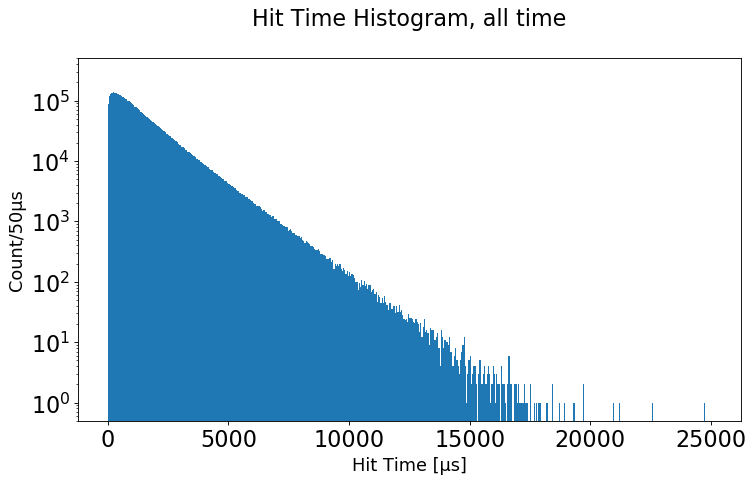

In [225]:
LHS    =  0.0
RHS    =  2.5e4
binlen =  50
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,bins=setbins)

plt.title('Hit Time Histogram, all time\n')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Count/{:}μs'.format(binlen))
plt.yscale('log')
plt.ylim(5e-1,5e5)
plt.show()

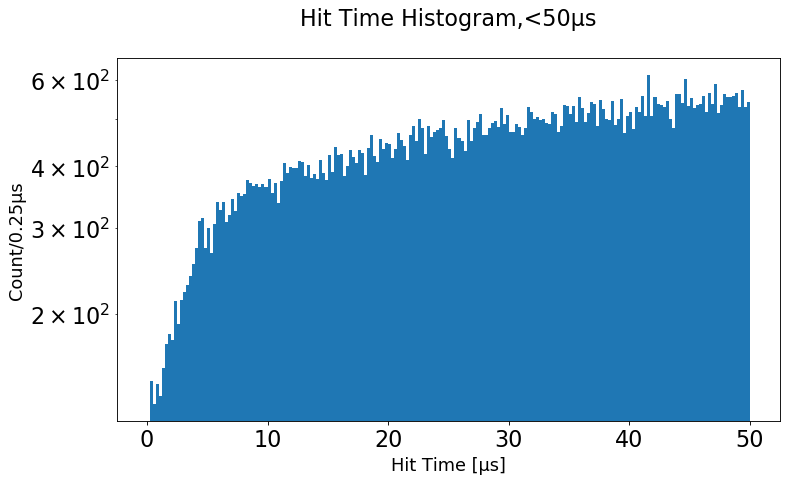

In [226]:
LHS    = 0
RHS    = 50
nbins  = 200
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,bins=setbins)

plt.title('Hit Time Histogram,<{}μs\n'.format(RHS)+'')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Count/{:}μs'.format(binlen))
plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

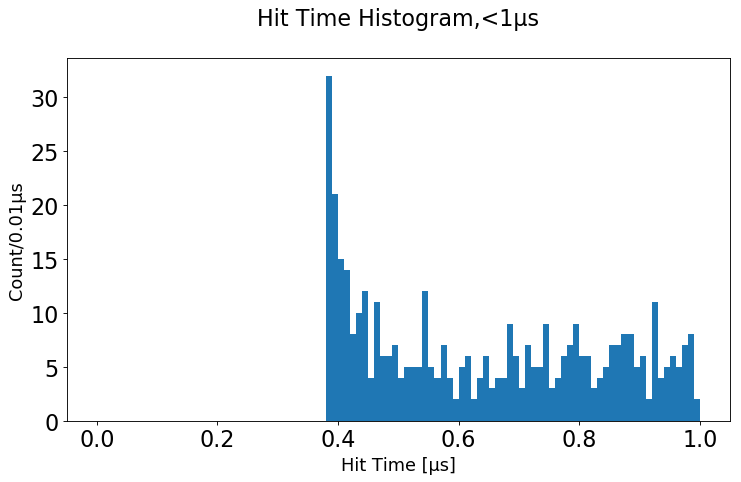

In [227]:
LHS    = 0.0
RHS    = 1
nbins  = 100
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,bins=setbins)

plt.title('Hit Time Histogram,<{}μs\n'.format(RHS)+'')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Count/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(9e3,3.1e4)
plt.show()

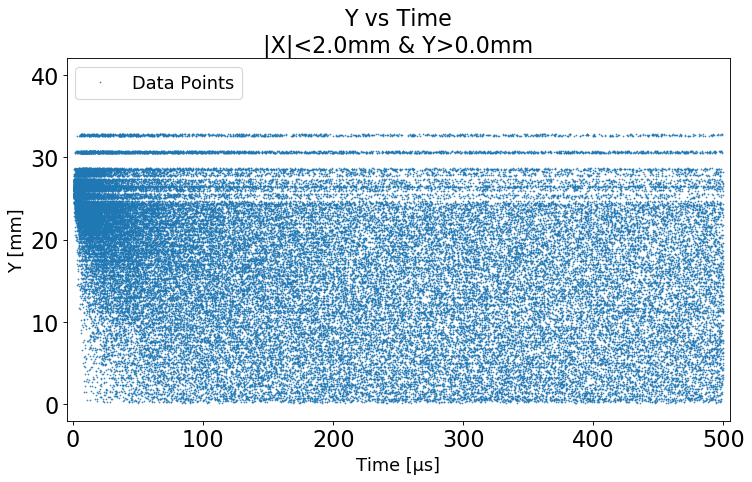

In [228]:
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 500
cutXYT = (Y3_top>ylim)&(np.abs(X3_top)<xlim)&(Time3_top>tlim0)&(Time3_top<tlim1)
plt.plot(Time3_top[cutXYT],Y3_top[cutXYT],'.', markersize=1, label='Data Points')
plt.title('Y vs Time\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Time [μs]')
plt.ylabel('Y [mm]')
plt.ylim(-2,42)
plt.xlim(-5,505)
plt.legend(loc='upper left')
plt.show()

In [229]:
if 'YvsTime' in locals():
    del YvsTime 

#maxbin = 37
#minbin = 1
#binlen = 1
#binnum = int((maxbin-minbin)/binlen)
#a = TProfile('th1d', 'profile1', binnum, minbin, maxbin)
bins   = np.array([0,2.]+list(range(4,501,2)))
xbn    = len(bins)-1
YvsTime= TProfile('YvsTime','YvsTime',xbn,bins)

new_array = np.column_stack((Time3_top[cutXYT], Y3_top[cutXYT]))
fill_profile(YvsTime,new_array)

profile_Time  = np.array([YvsTime.GetBinCenter(xbin) for xbin in range(1,xbn+1)])
profile_mean  = np.array([YvsTime.GetBinContent(xbin) for xbin in range(1,xbn+1)])
profile_error = np.array([YvsTime.GetBinError(xbin) for xbin in range(1,xbn+1)])
bin_entr      = np.array([YvsTime.GetBinEntries(xbin) for xbin in range(1,xbn+1)])
profile_std   = np.sqrt(bin_entr)*profile_error # std of mean -> std of the data

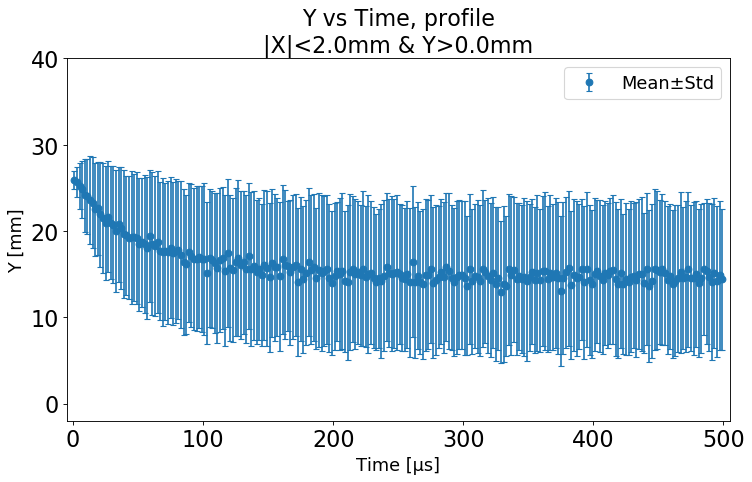

In [230]:
plt.errorbar(profile_Time, profile_mean, yerr=profile_std, fmt='o', capsize=3, label='Mean±Std')
plt.title('Y vs Time, profile'+'\n|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Time [μs]')
plt.ylabel('Y [mm]')
plt.xlim(-5,505)
plt.ylim(-2,40)

plt.legend()
plt.show()

In [235]:
def Approach_mean(x, A, a):
    return -A*(x**2)/(x**2+a)+25

In [236]:
params, covariance = curve_fit(Approach_mean, profile_Time, profile_mean, p0=[16, 1])
A, a= params
print(A,a)

10.349426664535196 1816.8335129025709


In [237]:
Approach_mean(100, A, a)/13.66

1.1890039254455815

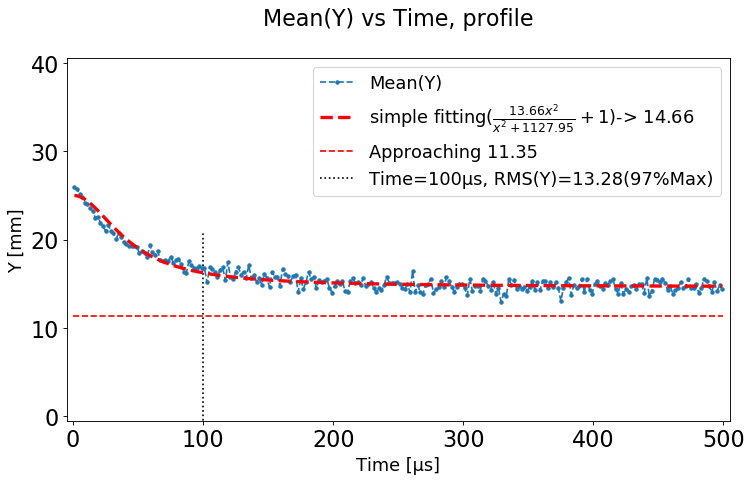

In [238]:
plt.plot(profile_Time, profile_mean,'.--',label='Mean(Y)')
plt.plot(profile_Time, Approach_mean(profile_Time,A,a),'r--',linewidth=3,
         label='simple fitting'+r'($\frac{13.66x^2}{x^2+1127.95}+1$)'+'-> 14.66')
plt.hlines(A+1, 0,500,colors='r',linestyles='dashed',label='Approaching {:.2f}'.format(A+1))
plt.vlines(100,-1,21,colors='k',linestyles='dotted',label='Time=100μs, RMS(Y)=13.28(97%Max)')
plt.title('Mean(Y) vs Time, profile' +'\n')
plt.xlabel('Time [μs]')
plt.ylabel('Y [mm]')
plt.xlim(-5,505)
plt.ylim(-0.5,40.5)

plt.legend()
plt.show()

In [115]:
def Approach_std(x, A, a):
    return A*(x**2)/(x**2+a)+1

In [116]:
params, covariance = curve_fit(Approach_std, profile_Time, profile_std, p0=[10, 100])
A, a= params
print(A,a)

7.5902304013734065 311.27616555999896


In [117]:
Approach_std(100, A, a)

8.361096996630764

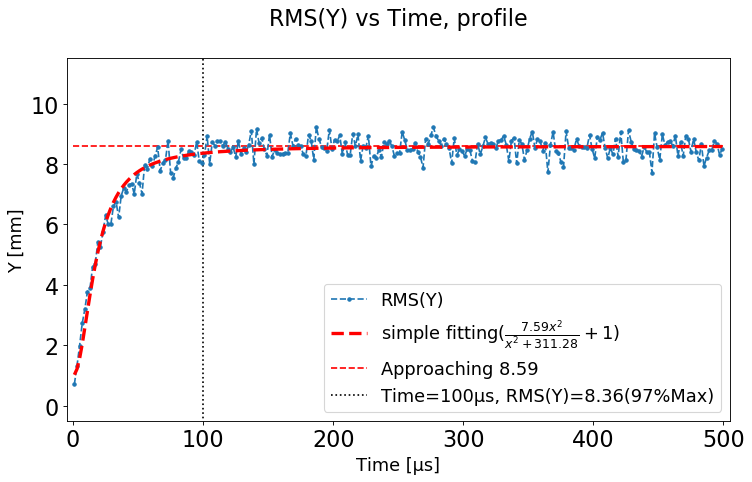

In [118]:
plt.plot(profile_Time, profile_std,'.--',label='RMS(Y)')
plt.plot(profile_Time, Approach_std(profile_Time,A,a),'r--',linewidth=3,
         label='simple fitting'+r'($\frac{7.59x^2}{x^2+311.28}+1$)')
plt.hlines(A+1, 0,500,colors='r',linestyles='dashed',label='Approaching {:.2f}'.format(A+1))
plt.vlines(100,-1,21, colors='k',linestyles='dotted',label='Time=100μs, RMS(Y)=8.36(97%Max)')
plt.title('RMS(Y) vs Time, profile' +'\n')
plt.xlabel('Time [μs]')
plt.ylabel('Y [mm]')
plt.xlim(-5,505)
plt.ylim(-0.5,11.5)

plt.legend()
plt.show()

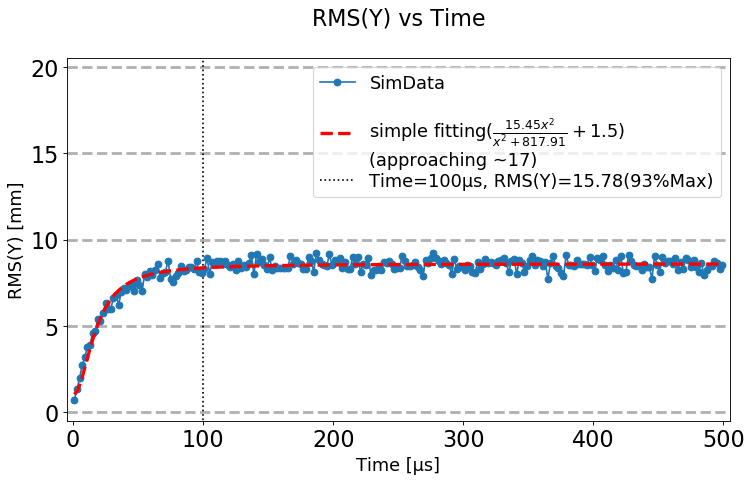

In [80]:
plt.plot(profile_Time,profile_std,'o-',label='SimData')
plt.plot(profile_Time,Approach16(profile_Time,A,a),'r--',linewidth=3,
         label='simple fitting'+r'($\frac{15.45x^2}{x^2+817.91}+1.5$)'+'\n(approaching ~17)')
plt.vlines(100,-1,21,colors='k',linestyles='dotted',label='Time=100μs, RMS(Y)=15.78(93%Max)')
plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Y) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

## 1.2 Bottom Surface

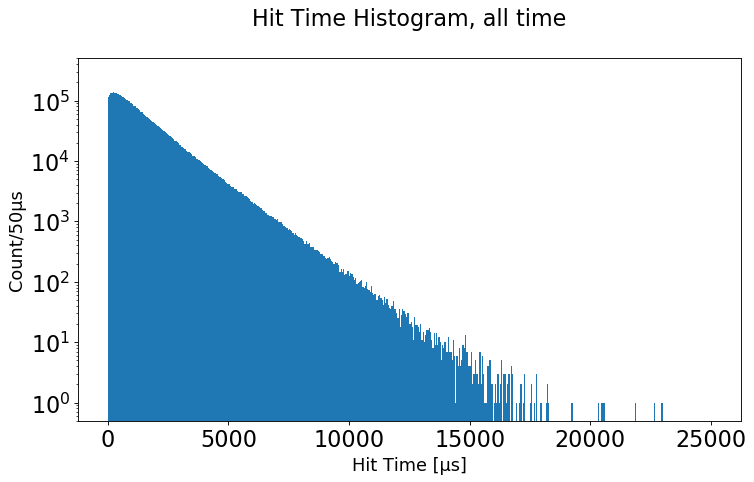

In [176]:
LHS    =  0.0
RHS    =  2.5e4
binlen =  50
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_bottom,bins=setbins)

plt.title('Hit Time Histogram, all time\n')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Count/{:}μs'.format(binlen))
plt.yscale('log')
plt.ylim(5e-1,5e5)
plt.show()

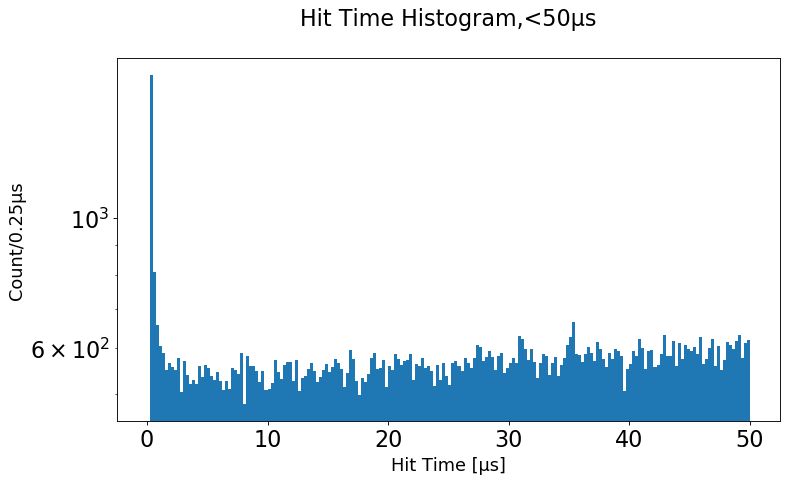

In [177]:
LHS    = 0
RHS    = 50
nbins  = 200
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_bottom,bins=setbins)

plt.title('Hit Time Histogram,<{}μs\n'.format(RHS)+'')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Count/{:}μs'.format(binlen))
plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

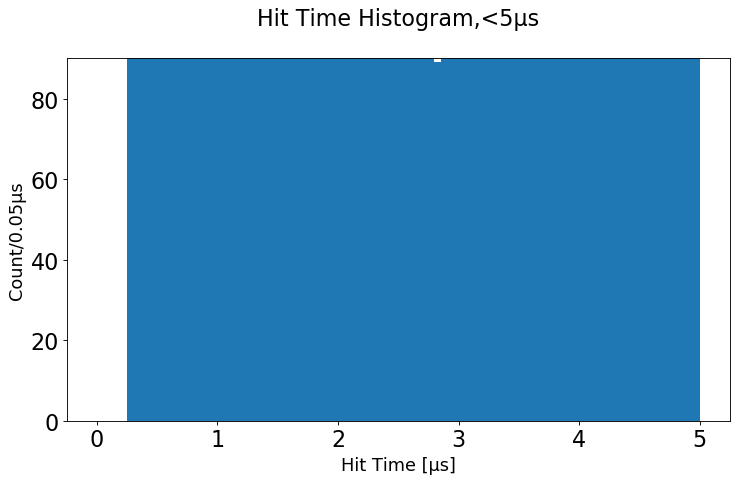

In [178]:
LHS    = 0.0
RHS    = 5
nbins  = 100
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_bottom,bins=setbins)

plt.title('Hit Time Histogram,<{}μs\n'.format(RHS)+'')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Count/{:}μs'.format(binlen))
#plt.yscale('log')
plt.ylim(0,90)
plt.show()

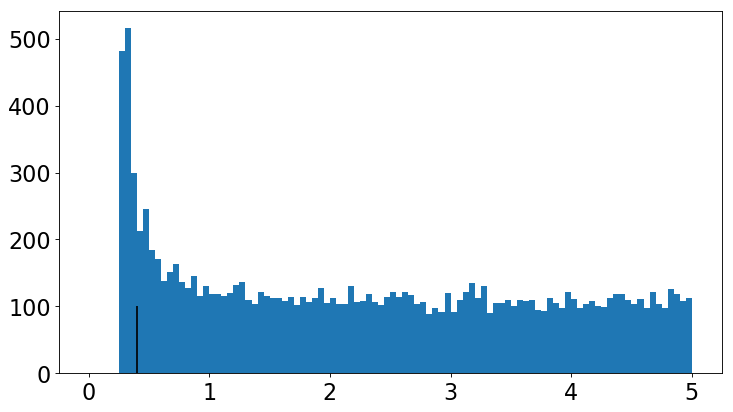

In [180]:
energies = plt.hist(Time3_bottom,bins=setbins)[0]
plt.vlines(0.4,0,100)
energies_bottom = energies[:20]

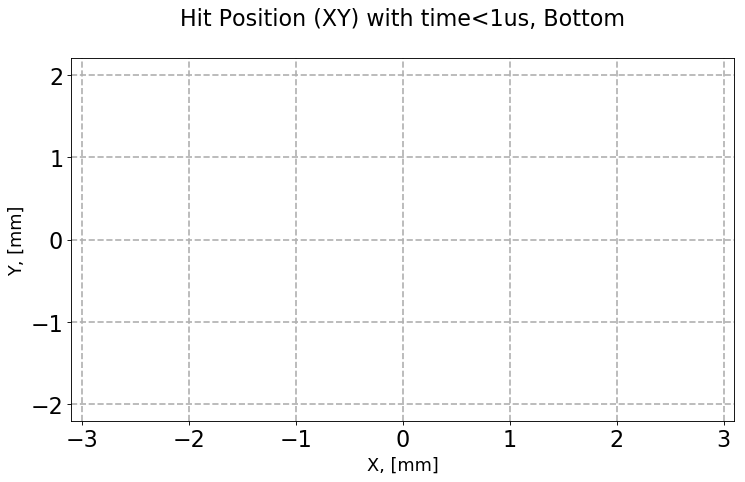

In [181]:
cutT = Time3_bottom<1
plt.plot(X3_bottom[cutT],Y3_bottom[cutT],'.')
plt.title('Hit Position (XY) with time<1us, Bottom\n')
plt.xlabel('X, [mm]')
plt.ylabel('Y, [mm]')
plt.xlim(-3.1,3.1)
plt.ylim(-2.2,2.2)
plt.grid(axis='both',ls='--',lw=1.5)
plt.show()

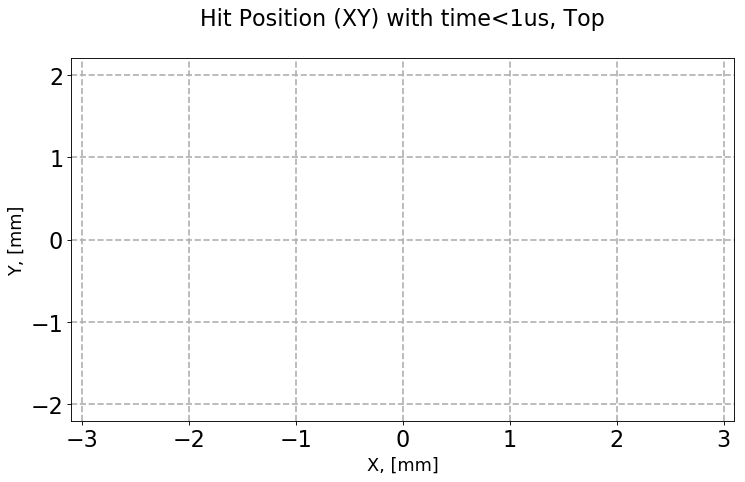

In [182]:
cutT = Time3_top<1
plt.plot(X3_top[cutT],Y3_top[cutT],'.')
plt.title('Hit Position (XY) with time<1us, Top\n')
plt.xlabel('X, [mm]')
plt.ylabel('Y, [mm]')
plt.xlim(-3.1,3.1)
plt.ylim(-2.2,2.2)
plt.grid(axis='both',ls='--',lw=1.5)
plt.show()

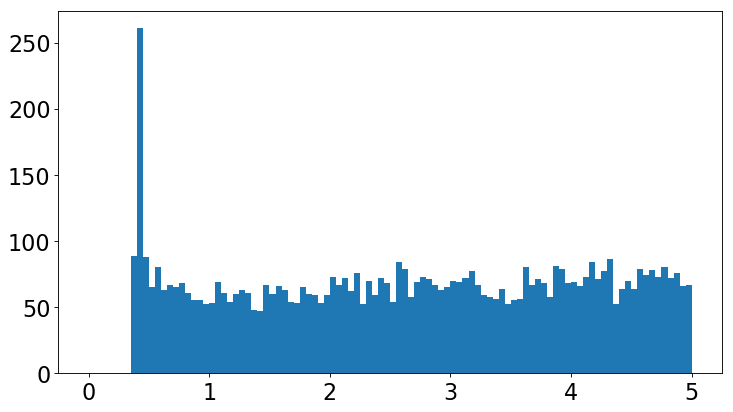

In [183]:
energies = plt.hist(Time3_top,bins=setbins)[0]
energies_top = energies[:20]

In [184]:
np.sum(energies_bottom)-np.sum(energies_top)

2150.0

# 2. Energy Collection vs Time

## 2.0 OF2T Templates

In [21]:
Template_2Tfast = np.load('./Template2Tfast.npy')
Template_2Tslow = np.load('./Template2Tslow.npy')

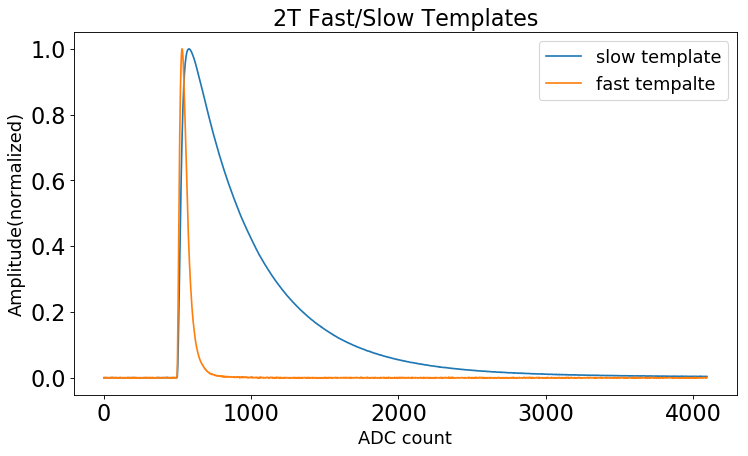

In [22]:
plt.plot(Template_2Tslow, label='slow template')
plt.plot(Template_2Tfast, label='fast tempalte')
plt.title('2T Fast/Slow Templates')
plt.xlabel('ADC count')
plt.ylabel('Amplitude(normalized)')
plt.legend()
plt.show()

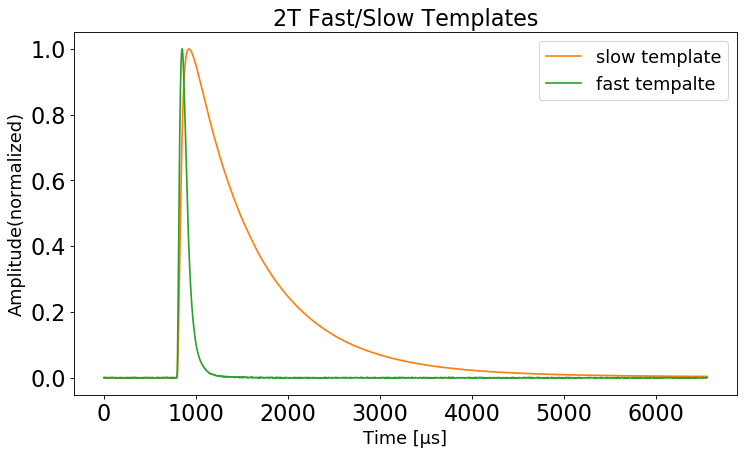

In [23]:
X_time = np.array(range(4096))*1.6
plt.plot(0)
plt.plot(X_time,Template_2Tslow, label='slow template')
plt.plot(X_time,Template_2Tfast, label='fast tempalte')
plt.title('2T Fast/Slow Templates')
plt.xlabel('Time [μs]')
plt.ylabel('Amplitude(normalized)')
plt.legend()
plt.show()

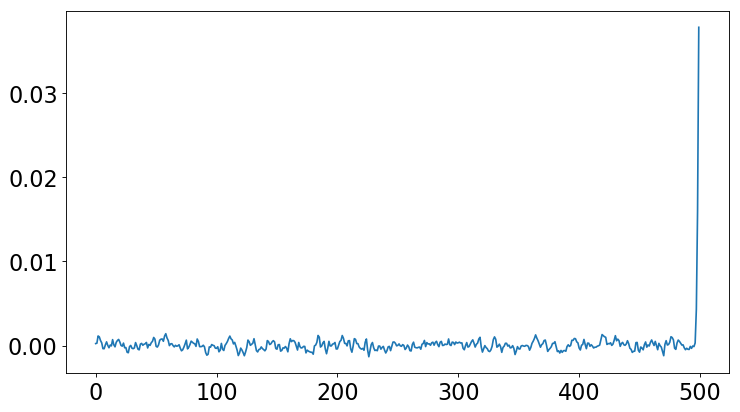

In [24]:
plt.plot(Template_2Tfast[:500])

In [25]:
np.max(Template_2Tfast[:450])

0.0014090325391921902

In [26]:
np.count_nonzero(Template_2Tfast[:500]<1.5e-3)

497

In [27]:
Template_2Tfast[450:500]

array([-7.89011706e-04, -1.74201949e-04, -2.96375405e-04, -5.10356740e-04,
        9.74960388e-05,  4.24844903e-04, -1.93077913e-04,  7.30956799e-05,
       -5.86979268e-05,  3.80746802e-04,  6.60518954e-04,  3.10154950e-04,
        4.16187791e-06,  4.91014397e-04, -2.62125693e-05, -4.98915734e-04,
        2.59940894e-04, -2.19610825e-05, -1.89219961e-04, -7.07730184e-04,
       -1.21200660e-03,  1.34208989e-04,  5.78852707e-04,  6.18524631e-05,
        1.25554646e-04,  3.87041929e-04,  1.04699984e-03,  9.51465467e-04,
        6.76888031e-04, -3.20640142e-04, -4.53806769e-04,  2.92020483e-04,
        6.52247624e-04,  4.94861186e-04,  2.70121500e-04,  5.69856806e-05,
        8.11522150e-05, -2.76254036e-04, -4.98532612e-04, -3.24763264e-04,
       -4.43356709e-04, -4.65863566e-04, -1.05235440e-04, -3.33182043e-04,
       -5.79907028e-05, -1.27596611e-04,  3.01741227e-04,  4.31863231e-03,
        1.60014038e-02,  3.78693851e-02])

## 2.1 Top Surface

In [28]:
timeslices = np.array([i*10 for i in range(101)])
#timeslices

In [29]:
timecut = 100
FastEnergy = np.sum(Ecoll_top[Time3_top<timecut])/1e3
FastRatio  = np.sum(Ecoll_top[Time3_top<timecut])/np.sum(Ecoll_top)
print(FastEnergy, FastRatio)

14.656932952975815 0.1205870404431278


In [30]:
N=len(timeslices)
ETopSum_time = np.zeros(N)
ETopRat_time = np.zeros(N)
for i in range(N):
    ETopSum_time[i]=np.sum(Ecoll_top[Time3_top<timeslices[i]])
    ETopRat_time[i]=ETopSum_time[i]/np.sum(Ecoll_top)

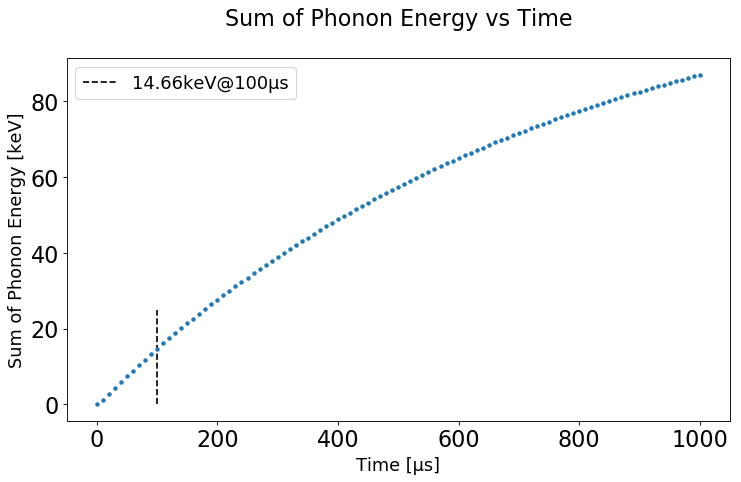

In [31]:
plt.plot(timeslices,ETopSum_time/1e3,'.')
plt.vlines(100, 0, 25, linestyles='dashed', label='14.66keV@100μs')
plt.title('Sum of Phonon Energy vs Time\n')
plt.xlabel('Time [μs]')
plt.ylabel('Sum of Phonon Energy [keV]')
plt.legend()
plt.show()

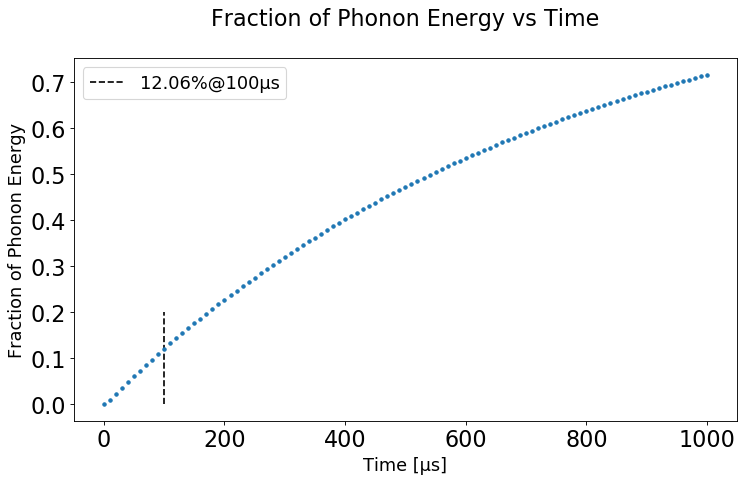

In [32]:
plt.plot(timeslices,ETopRat_time,'.')
plt.vlines(100, 0, 0.2, linestyles='dashed', label='12.06%@100μs')
plt.title('Fraction of Phonon Energy vs Time\n')
plt.xlabel('Time [μs]')
plt.ylabel('Fraction of Phonon Energy')
plt.legend()
plt.show()

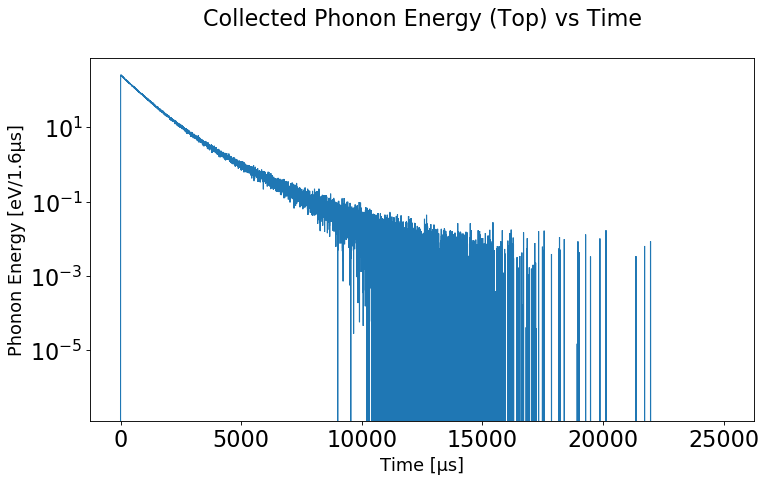

In [52]:
LHS    =  0.0
RHS    =  2.5e4
binlen =  1.6
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,weights=Ecoll_top,bins=setbins,histtype='step')

plt.title('Collected Phonon Energy (Top) vs Time\n')
plt.xlabel('Time [μs]')
plt.ylabel('Phonon Energy [eV/{:}μs]'.format(binlen))
plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

In [41]:
shift_time = 497*1.6
headzeros  = np.zeros(497)

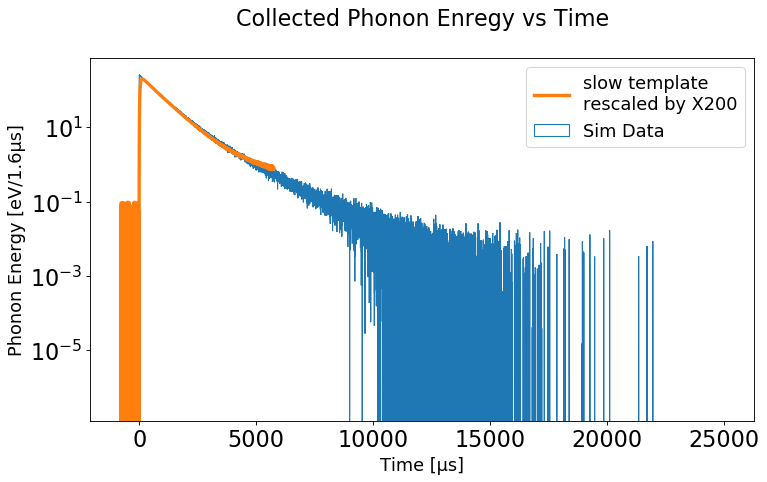

In [53]:
LHS    = 0.0
RHS    = 2.5e4
binlen = 1.6
nbins  = int((RHS-LHS)/binlen)

setbins= np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,weights=Ecoll_top,bins=setbins, label='Sim Data',histtype='step')
plt.plot((X_time-shift_time),Template_2Tslow*200, lw=3,label='slow template\nrescaled by X200')


plt.title('Collected Phonon Enregy vs Time\n')
plt.xlabel('Time [μs]')
plt.ylabel('Phonon Energy [eV/{:}μs]'.format(binlen))
plt.yscale('log')
#plt.ylim(1e-5,5e2)
plt.legend()
plt.show()

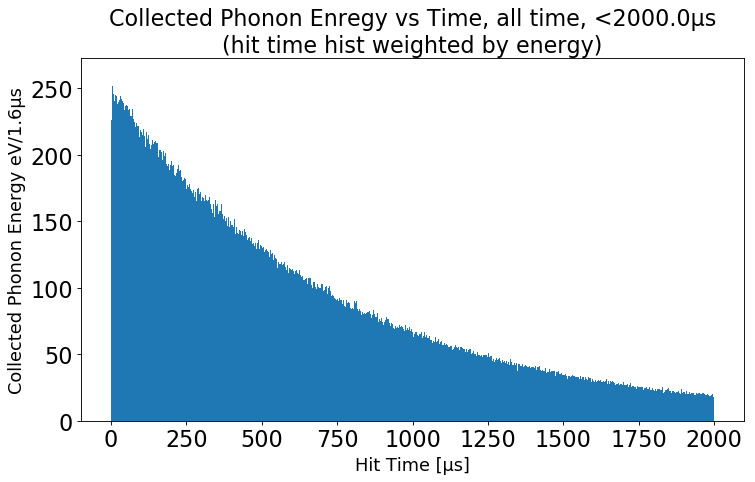

In [137]:
LHS    = 0.0
RHS    = 2e3
binlen = 1.6
nbins  = int((RHS-LHS)/binlen)

setbins= np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,weights=Ecoll_top,bins=setbins)

plt.title('Collected Phonon Enregy vs Time, all time, <{}μs\n'.format(RHS)+'(hit time hist weighted by energy)')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Collected Phonon Energy eV/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

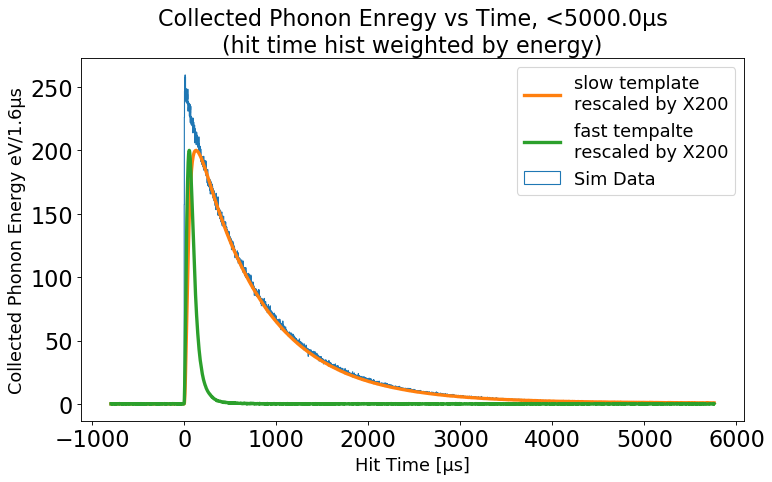

In [138]:
LHS    = 0.0
RHS    = 5e3
binlen = 1.6
nbins  = int((RHS-LHS)/binlen)

setbins= np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,weights=Ecoll_top,bins=setbins, label='Sim Data',histtype='step')
plt.plot(X_time-shift_time,Template_2Tslow*200, lw=3,label='slow template\nrescaled by X200')
plt.plot(X_time-shift_time,Template_2Tfast*200, lw=3,label='fast tempalte\nrescaled by X200')
#plt.plot(X_time,Template_2Tfast*20+Template_2Tslow*200, label='total tempalte')


plt.title('Collected Phonon Enregy vs Time, <{}μs\n'.format(RHS)+'(hit time hist weighted by energy)')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Collected Phonon Energy eV/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.legend()
plt.show()

In [139]:
Template_2Tslow

array([-1.12373952e-04, -2.09693100e-04, -9.29056093e-05, ...,
        4.12363721e-03,  3.87382690e-03,  3.87826507e-03])

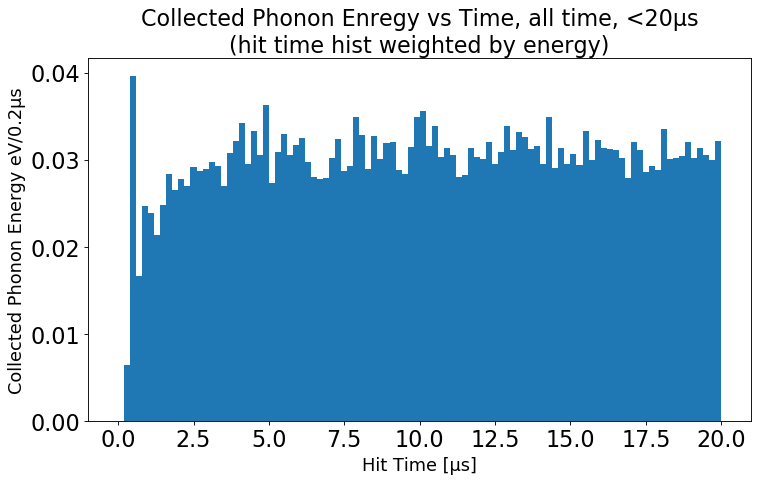

In [140]:
LHS    = 0.0
RHS    = 20
nbins  = 100
binlen = (RHS-LHS)/nbins
setbins= np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top,weights=Ecoll_top/1e3,bins=setbins)

plt.title('Collected Phonon Enregy vs Time, all time, <{}μs\n'.format(RHS)+'(hit time hist weighted by energy)')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Collected Phonon Energy eV/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

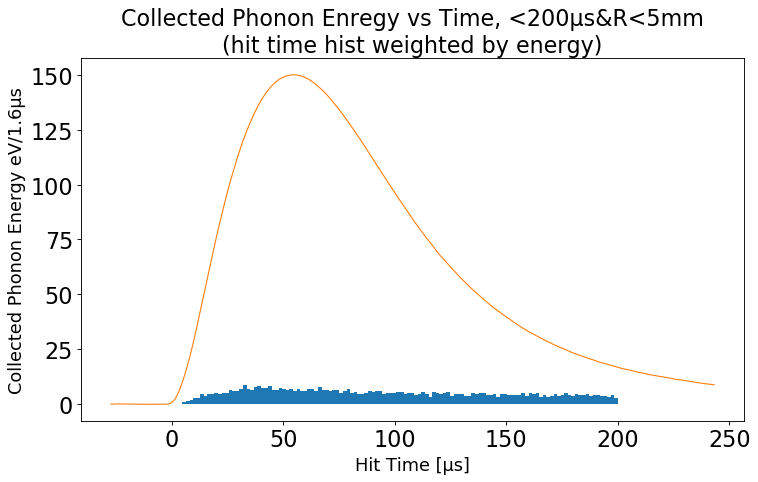

In [141]:
cutR = (R3_top<5)

LHS    = 0.0
RHS    = 200
binlen = 1.6
nbins  = int((RHS-LHS)/binlen)
setbins= np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_top[cutR],weights=Ecoll_top[cutR],bins=setbins)
plt.plot((X_time-shift_time)[480:650],Template_2Tfast[480:650]*150, lw=1,label='fast tempalte\nrescaled by X150')

plt.title('Collected Phonon Enregy vs Time, <{}μs&R<5mm\n'.format(RHS)+'(hit time hist weighted by energy)')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Collected Phonon Energy eV/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

## 2.2 Bottom Surface

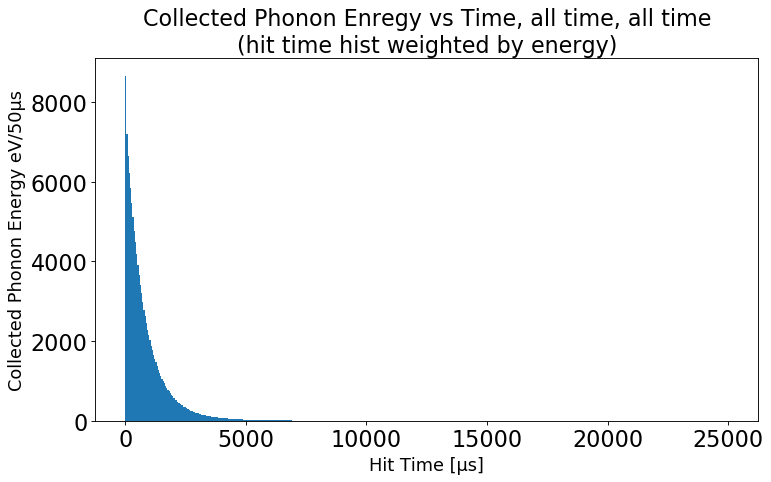

In [142]:
LHS    =  0.0
RHS    =  2.5e4
binlen =  50
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_bottom,weights=Ecoll_bottom,bins=setbins)

plt.title('Collected Phonon Enregy vs Time, all time, all time\n'+'(hit time hist weighted by energy)')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Collected Phonon Energy eV/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

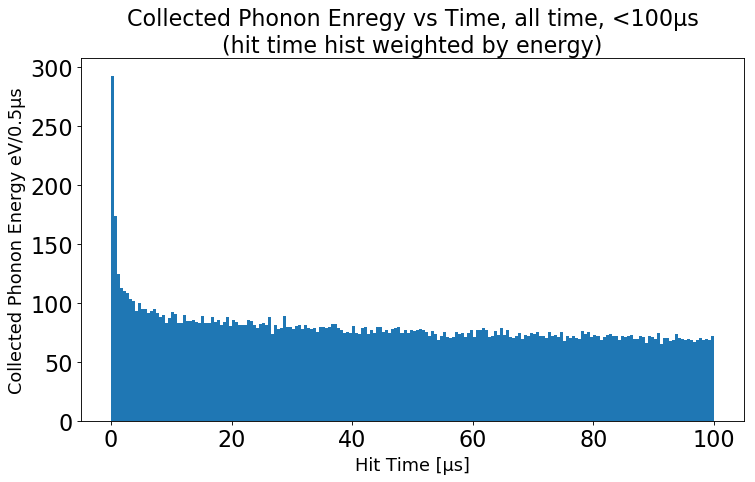

In [143]:
LHS    = 0.0
RHS    = 100
nbins  = 200
binlen = (RHS-LHS)/nbins
setbins= np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_bottom,weights=Ecoll_bottom,bins=setbins)

plt.title('Collected Phonon Enregy vs Time, all time, <{}μs\n'.format(RHS)+'(hit time hist weighted by energy)')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Collected Phonon Energy eV/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

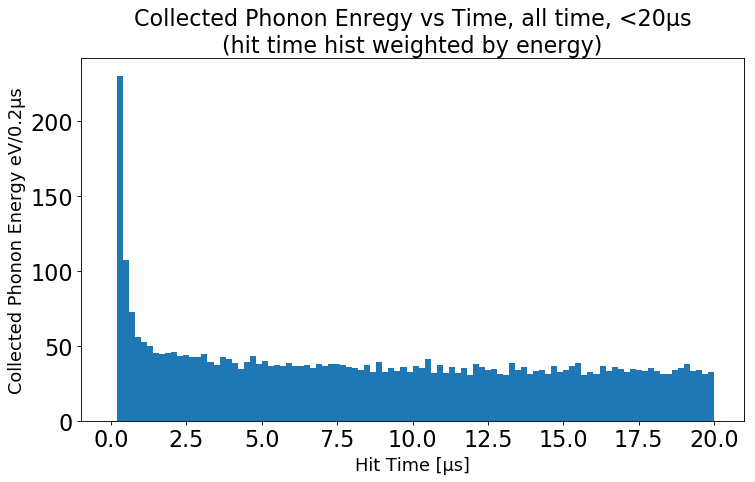

In [144]:
LHS    = 0.0
RHS    = 20
nbins  = 100
binlen = (RHS-LHS)/nbins
setbins= np.linspace(LHS,RHS,nbins+1)
plt.hist(Time3_bottom,weights=Ecoll_bottom,bins=setbins)

plt.title('Collected Phonon Enregy vs Time, all time, <{}μs\n'.format(RHS)+'(hit time hist weighted by energy)')
plt.xlabel('Hit Time [μs]')
plt.ylabel('Collected Phonon Energy eV/{:}μs'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

# 2. Energy Collection vs Radius

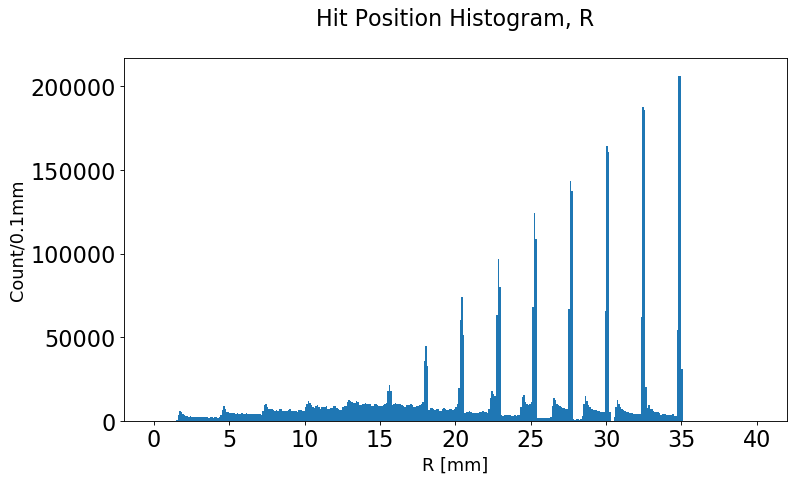

In [125]:
LHS    =  0.0
RHS    =  40.0
binlen =  0.1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(R3_top,bins=setbins)

plt.title('Hit Position Histogram, R\n')
plt.xlabel('R [mm]')
plt.ylabel('Count/{:}mm'.format(binlen))
#plt.yscale('log')
plt.show()

## 2.1 Top Surface

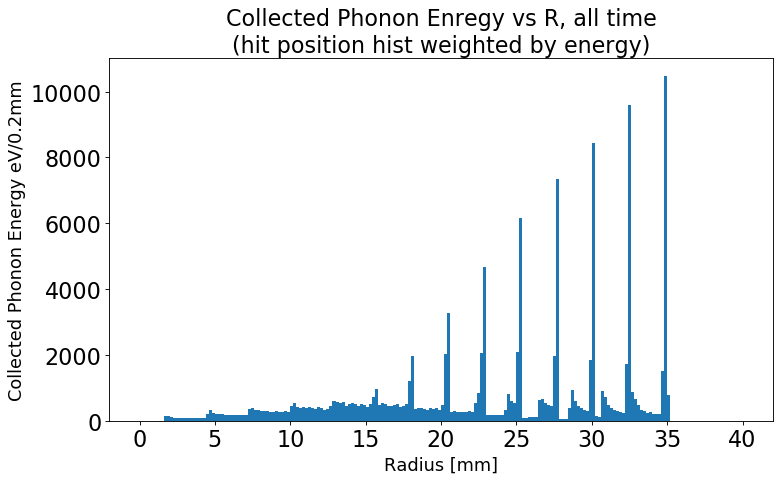

In [185]:
LHS    = 0.0
RHS    = 40
nbins  = 200
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(R3_top,weights=Ecoll_top,bins=setbins)

plt.title('Collected Phonon Enregy vs R, all time\n'+'(hit position hist weighted by energy)')
plt.xlabel('Radius [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

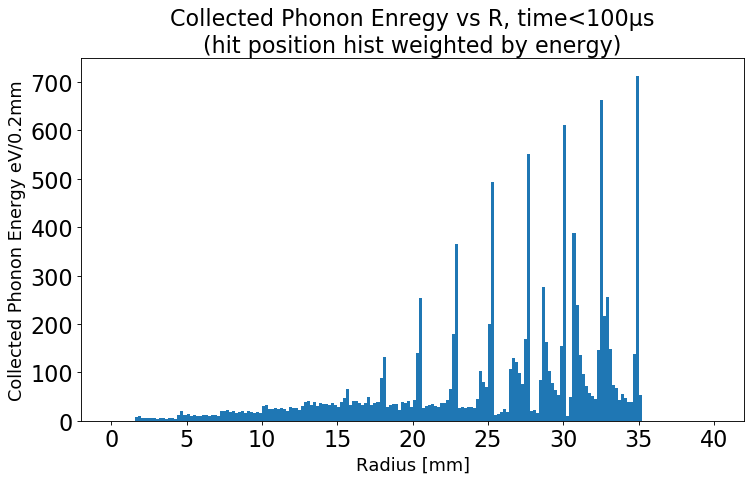

In [186]:
LHS    = 0.0
RHS    = 40
nbins  = 200
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
cutT = Time3_top<100
plt.hist(R3_top[cutT],weights=Ecoll_top[cutT],bins=setbins)

plt.title('Collected Phonon Enregy vs R, time<100μs\n'+'(hit position hist weighted by energy)')
plt.xlabel('Radius [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

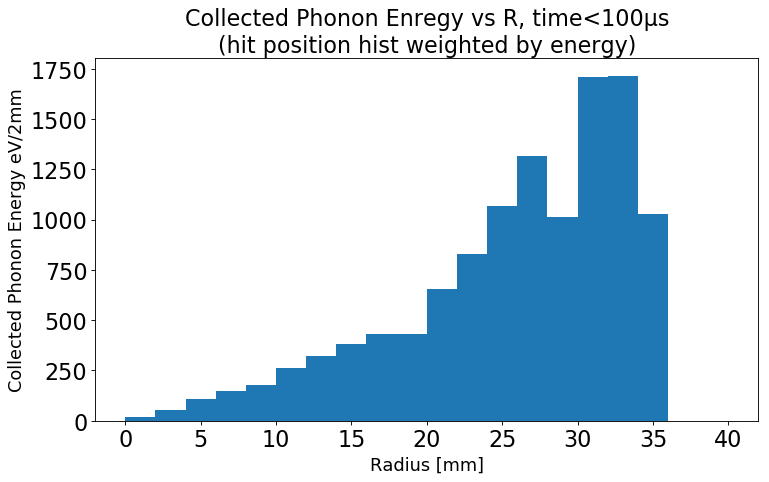

In [187]:
LHS    = 0.0
RHS    = 40
binlen = 2
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
cutT = Time3_top<100
plt.hist(R3_top[cutT],weights=Ecoll_top[cutT],bins=setbins)

plt.title('Collected Phonon Enregy vs R, time<100μs\n'+'(hit position hist weighted by energy)')
plt.xlabel('Radius [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

In [188]:
np.sum(Ecoll_top[cutT])/(123.24*0.98)/1000

0.09662802735669149

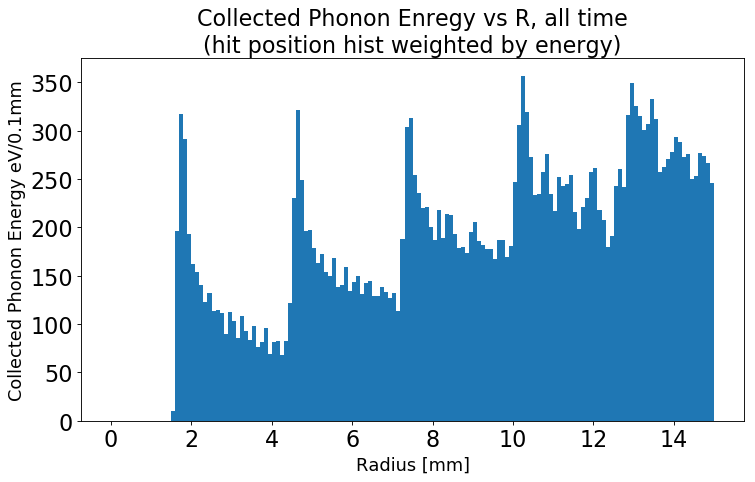

In [129]:
LHS    = 0.0
RHS    = 15
nbins  = 150
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(R3_top,weights=Ecoll_top,bins=setbins)

plt.title('Collected Phonon Enregy vs R, all time\n'+'(hit position hist weighted by energy)')
plt.xlabel('Radius [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

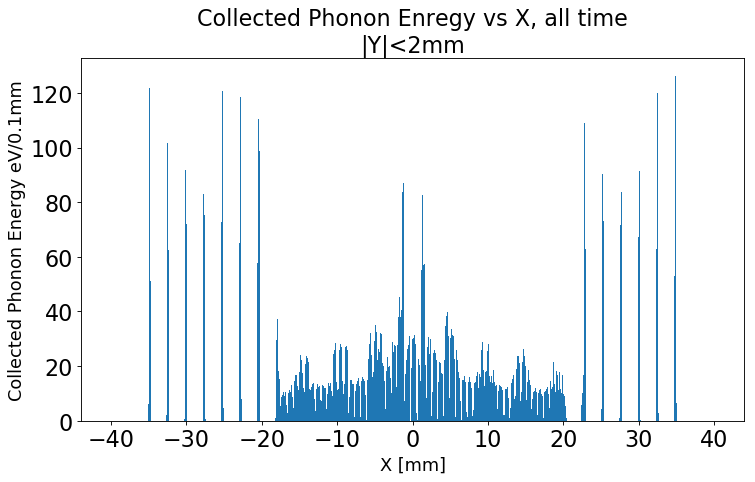

In [130]:
LHS    = -40.0
RHS    =  40.0
binlen =  0.1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
cutY = (np.abs(Y3_top)<2)
plt.hist(X3_top[cutY],weights=Ecoll_top[cutY],bins=setbins)

plt.title('Collected Phonon Enregy vs X, all time\n'+'|Y|<2mm')
plt.xlabel('X [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.show()
plt.show()

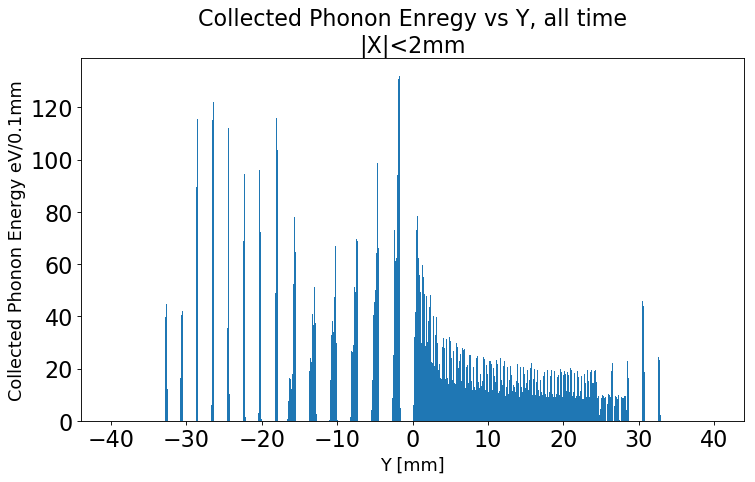

In [131]:
LHS    = -40.0
RHS    =  40.0
binlen =  0.1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
cutX = (np.abs(X3_top)<2)
plt.hist(Y3_top[cutX],weights=Ecoll_top[cutX],bins=setbins)

plt.title('Collected Phonon Enregy vs Y, all time\n'+'|X|<2mm')
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.show()
plt.show()

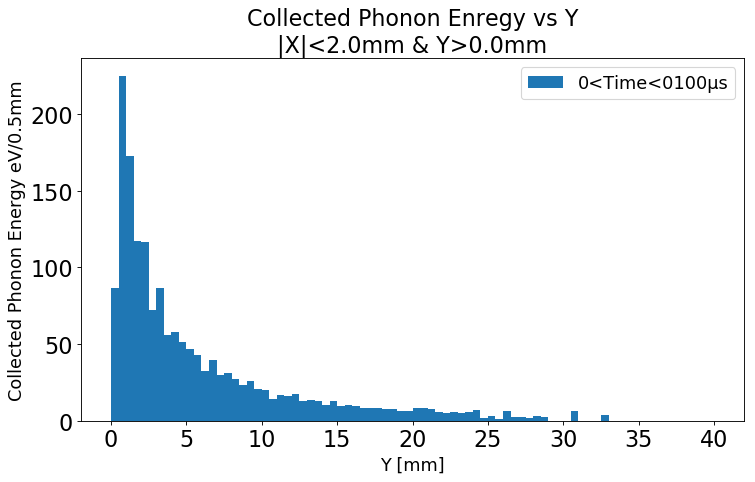

In [227]:
LHS    =  0.0
RHS    =  40.0
binlen =  0.5
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXYT = (Y3_top>ylim)&(np.abs(X3_top)<xlim)&(Time3_top>tlim0)&(Time3_top<tlim1)
gaussdata=plt.hist(Y3_top[cutXYT],weights=Ecoll_top[cutXYT],bins=setbins,label='{}<Time<{:04d}μs'.format(tlim0,tlim1))

plt.title('Collected Phonon Enregy vs Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.1e2)
plt.show()

In [228]:
def gengaussian(x, A, mu, a, b):
    return A * np.exp(-(abs((x-mu)/a))**b)

In [242]:
hitR = 1

y_data = gaussdata[0][1:50]
x_data = gaussdata[1][1:50]+0.5
x_data = x_data[y_data!=0]
y_data = y_data[y_data!=0]

params, covariance = curve_fit(gengaussian, x_data, y_data, p0=[100, hitR, 1,0.5])
A, mu, a, b = params
print(A,mu,a,b)

324.3087699209221 1.113808607371747 1.0112082607682578 0.46014113549178354


In [243]:
fitdataX = np.linspace(-1,40,410+1)

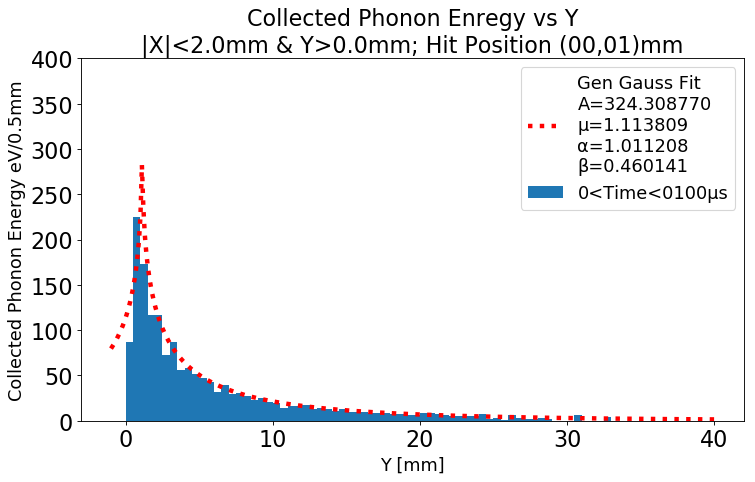

In [244]:
plt.hist(Y3_top[cutXYT],weights=Ecoll_top[cutXYT],bins=setbins,label='{}<Time<{:04d}μs'.format(tlim0,tlim1))
fitlabel = 'Gen Gauss Fit\nA={:.6f}\nμ={:.6f}\nα={:.6f}\nβ={:.6f}'.format(A, mu, np.abs(a), b)
plt.plot(fitdataX,gengaussian(fitdataX,A,mu,a,b),'r:',linewidth=4,label=fitlabel)
plt.title('Collected Phonon Enregy vs Y\n'+'|X|<{}mm & Y>{}mm; Hit Position (00,{:02d})mm'.format(xlim,ylim,hitR))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.legend()
plt.ylim(0,400)
plt.show()

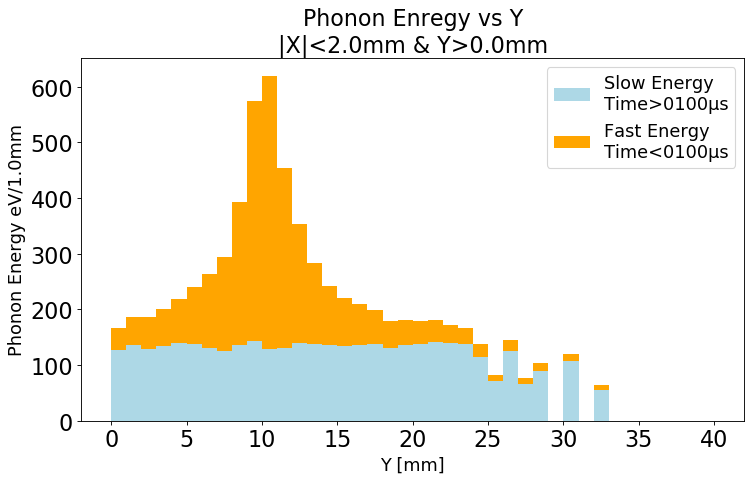

In [108]:
LHS    =  0.0
RHS    =  40.0
binlen =  1.
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXY = (Y3_top>ylim)&(np.abs(X3_top)<xlim)
cutTF = (Time3_top<tlim1)
cutTS = (Time3_top>tlim1)
Y3_top_2T = [Y3_top[cutXY&cutTS],Y3_top[cutXY&cutTF]]
Ecoll_top_fast = Ecoll_top[cutXY&cutTF]
Ecoll_top_slow = Ecoll_top[cutXY&cutTS]
Ecoll_top_2T   =[Ecoll_top_slow,Ecoll_top_fast]
labels_2T = ['Slow Energy\nTime>{:04d}μs'.format(tlim1),'Fast Energy\nTime<{:04d}μs'.format(tlim1)]
plt.hist(Y3_top_2T,weights=Ecoll_top_2T,bins=setbins,color=['lightblue','orange'],
         alpha=1,label=labels_2T,stacked=True)

plt.title('Phonon Enregy vs Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.1e2)
plt.show()

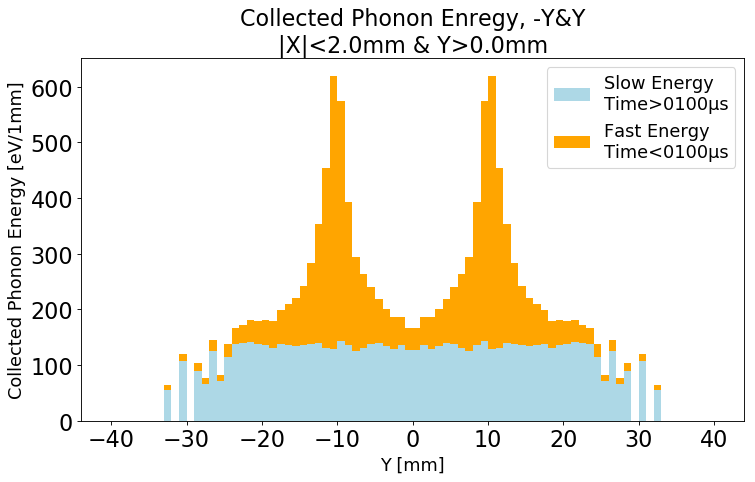

In [104]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 100
tlim1 = 1e5
cutXY = (Y3_top>ylim)&(np.abs(X3_top)<xlim)
cutTF = (Time3_top<tlim0)
cutTS = (Time3_top>tlim0)
Y3_top_dual_fast    = np.concatenate((  -Y3_top[cutXY&cutTF],   Y3_top[cutXY&cutTF]))
Ecoll_top_dual_fast = np.concatenate((Ecoll_top[cutXY&cutTF],Ecoll_top[cutXY&cutTF]))
Y3_top_dual_slow    = np.concatenate((  -Y3_top[cutXY&cutTS],   Y3_top[cutXY&cutTS]))
Ecoll_top_dual_slow = np.concatenate((Ecoll_top[cutXY&cutTS],Ecoll_top[cutXY&cutTS]))
Y3_top_2T = [Y3_top_dual_slow,Y3_top_dual_fast]
Ecoll_top_2T = [Ecoll_top_dual_slow,Ecoll_top_dual_fast]
labels_2T = ['Slow Energy\nTime>{:04d}μs'.format(tlim0),'Fast Energy\nTime<{:04d}μs'.format(tlim0)]
plt.hist(Y3_top_2T,weights=Ecoll_top_2T,bins=setbins,color=['lightblue','orange'],
         alpha=1,label=labels_2T,stacked=True)
#plt.hist(,weights=Ecoll_top_dual_fast,bins=setbins,
#         label='Time<{:04d}μs'.format(tlim0),cumulative='True')


plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

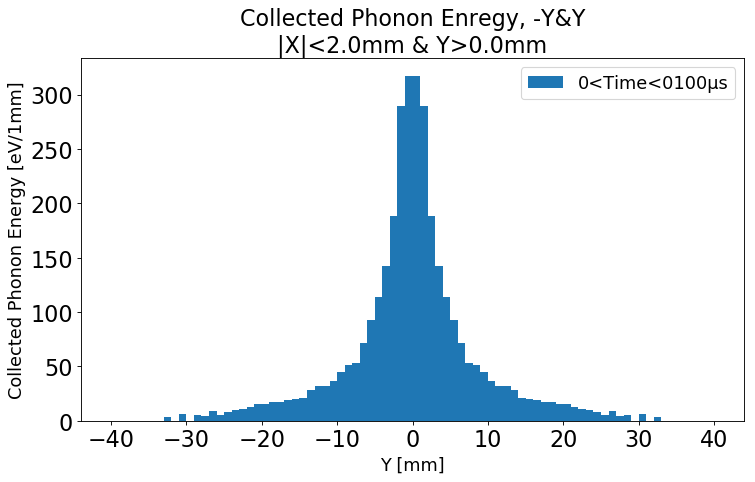

In [85]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXYT = (Y3_top>ylim)&(np.abs(X3_top)<xlim)&(Time3_top>tlim0)&(Time3_top<tlim1)
Y3_top_dual    = np.concatenate((-Y3_top[cutXYT],Y3_top[cutXYT]))
Ecoll_top_dual = np.concatenate((Ecoll_top[cutXYT],Ecoll_top[cutXYT]))
gaussdata = plt.hist(Y3_top_dual,weights=Ecoll_top_dual,bins=setbins,label='{}<Time<{:04d}μs'.format(tlim0,tlim1))

plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

In [88]:
def gaussian1(x, A, mu, sigma):
    return A * np.exp(-1/2*(abs((x-mu)/sigma))**0.6)
    #return A * np.exp(-1*(abs((x-mu)/sigma))**0.6)

y_data = gaussdata[0]
x_data = gaussdata[1][1:]-0.5
params, covariance = curve_fit(gaussian1, x_data, y_data, p0=[500, np.mean(x_data), np.std(x_data)])
A, mu, sigma = params
print(A,mu,sigma)

519.5438892115795 4.4718124953651214e-07 0.7182974550355242


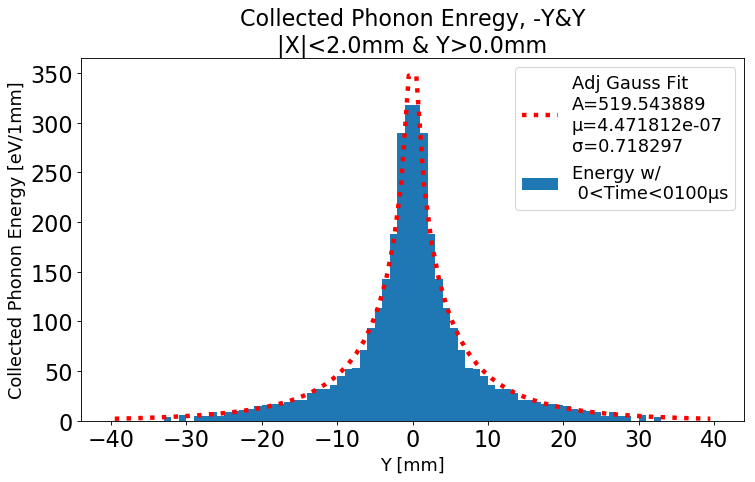

In [89]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXYT = (Y3_top>ylim)&(np.abs(X3_top)<xlim)&(Time3_top>tlim0)&(Time3_top<tlim1)
Y3_top_dual    = np.concatenate((-Y3_top[cutXYT],Y3_top[cutXYT]))
Ecoll_top_dual = np.concatenate((Ecoll_top[cutXYT],Ecoll_top[cutXYT]))
plt.hist(Y3_top_dual,weights=Ecoll_top_dual,bins=setbins,label='Energy w/\n {}<Time<{:04d}μs'.format(tlim0,tlim1))
fitlabel = 'Adj Gauss Fit\nA={:.6f}\nμ={:.6e}\nσ={:.6f}'.format(A, mu, sigma)
plt.plot(x_data,gaussian1(x_data,A,mu,sigma),'r:',linewidth=4,label=fitlabel)

plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

In [124]:
def gengaussian(x, A, mu, a, b):
    return A * np.exp(-(abs((x-mu)/a))**b)

In [125]:
y_data = gaussdata[0]
x_data = gaussdata[1][1:]-0.5

params, covariance = curve_fit(gengaussian, x_data, y_data, p0=[300, np.mean(x_data), 1,0.5])
A, mu, a, b = params
print(A,mu,a,b)

415.72566687254806 6.256630908235085e-06 3.468084698058025 0.7894498033377094


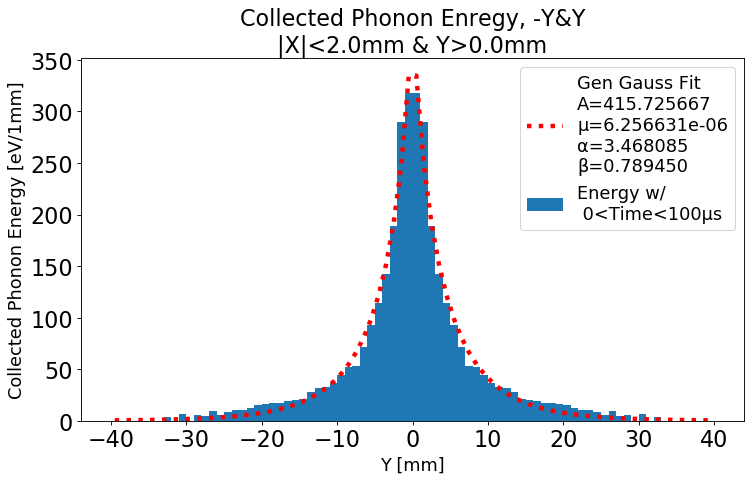

In [130]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXYT = (Y3_top>ylim)&(np.abs(X3_top)<xlim)&(Time3_top>tlim0)&(Time3_top<tlim1)
Y3_top_dual    = np.concatenate((-Y3_top[cutXYT],Y3_top[cutXYT]))
Ecoll_top_dual = np.concatenate((Ecoll_top[cutXYT],Ecoll_top[cutXYT]))
plt.hist(Y3_top_dual,weights=Ecoll_top_dual,bins=setbins,label='Energy w/\n {}<Time<{:d}μs'.format(tlim0,tlim1))
fitlabel = 'Gen Gauss Fit\nA={:.6f}\nμ={:.6e}\nα={:.6f}\nβ={:.6f}'.format(A, mu, np.abs(a), b)
plt.plot(x_data,gengaussian(x_data,A,mu,a,b),'r:',linewidth=4,label=fitlabel)

plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

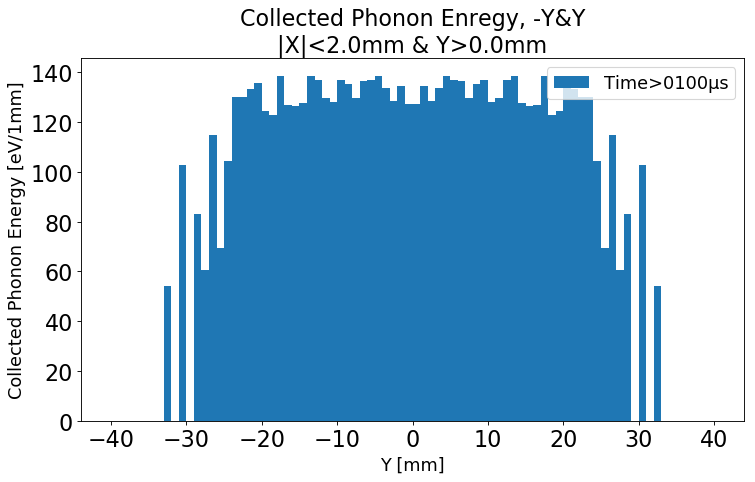

In [106]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 100
tlim1 = 1e5
cutXYT = (Y3_top>ylim)&(np.abs(X3_top)<xlim)&(Time3_top>tlim0)
Y3_top_dual    = np.concatenate((-Y3_top[cutXYT],Y3_top[cutXYT]))
Ecoll_top_dual = np.concatenate((Ecoll_top[cutXYT],Ecoll_top[cutXYT]))
plt.hist(Y3_top_dual,weights=Ecoll_top_dual,bins=setbins,label='Time>{:04d}μs'.format(tlim0))

plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

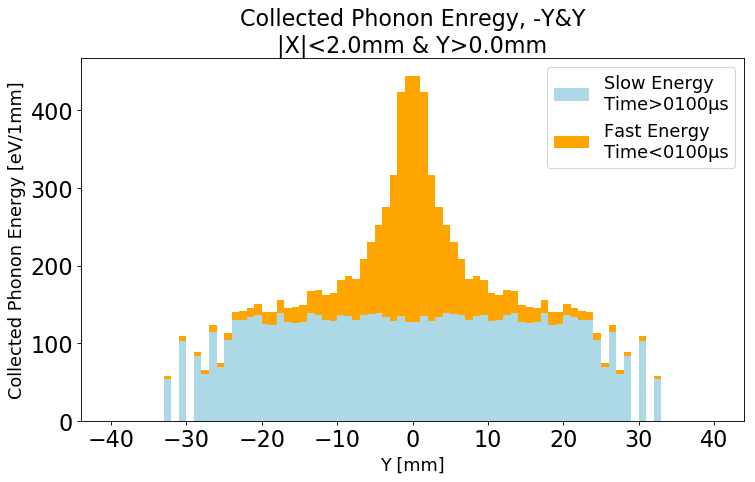

In [107]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 100
tlim1 = 1e5
cutXY = (Y3_top>ylim)&(np.abs(X3_top)<xlim)
cutTF = (Time3_top<tlim0)
cutTS = (Time3_top>tlim0)
Y3_top_dual_fast    = np.concatenate((  -Y3_top[cutXY&cutTF],   Y3_top[cutXY&cutTF]))
Ecoll_top_dual_fast = np.concatenate((Ecoll_top[cutXY&cutTF],Ecoll_top[cutXY&cutTF]))
Y3_top_dual_slow    = np.concatenate((  -Y3_top[cutXY&cutTS],   Y3_top[cutXY&cutTS]))
Ecoll_top_dual_slow = np.concatenate((Ecoll_top[cutXY&cutTS],Ecoll_top[cutXY&cutTS]))
Y3_top_2T = [Y3_top_dual_slow,Y3_top_dual_fast]
Ecoll_top_2T = [Ecoll_top_dual_slow,Ecoll_top_dual_fast]
labels_2T = ['Slow Energy\nTime>{:04d}μs'.format(tlim0),'Fast Energy\nTime<{:04d}μs'.format(tlim0)]
plt.hist(Y3_top_2T,weights=Ecoll_top_2T,bins=setbins,color=['lightblue','orange'],
         alpha=1,label=labels_2T,stacked=True)
#plt.hist(,weights=Ecoll_top_dual_fast,bins=setbins,
#         label='Time<{:04d}μs'.format(tlim0),cumulative='True')


plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

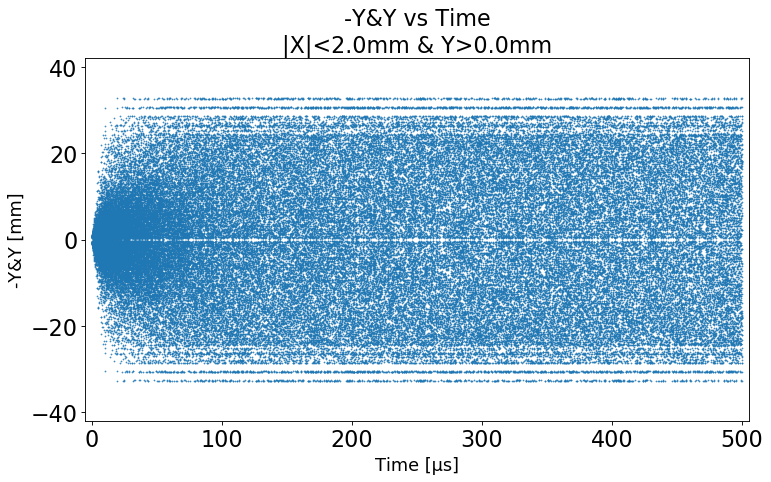

In [74]:
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 500
cutXYT = (Y3_top>ylim)&(np.abs(X3_top)<xlim)&(Time3_top>tlim0)&(Time3_top<tlim1)
Y3_top_dual = np.concatenate((-Y3_top[cutXYT],Y3_top[cutXYT]))
Time3_top_dual  = np.concatenate((Time3_top[cutXYT],  Time3_top[cutXYT]))
plt.plot(Time3_top_dual,Y3_top_dual,'.', markersize=1)
plt.title('-Y&Y vs Time\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Time [μs]')
plt.ylabel('-Y&Y [mm]'.format(binlen))
plt.ylim(-42,42)
plt.xlim(-5,505)
#plt.legend()
plt.show()

In [75]:
if 'YvsTime' in locals():
    del YvsTime 

#maxbin = 37
#minbin = 1
#binlen = 1
#binnum = int((maxbin-minbin)/binlen)
#a = TProfile('th1d', 'profile1', binnum, minbin, maxbin)
bins   = np.array([0,2.]+list(range(4,501,2)))
xbn    = len(bins)-1
YvsTime= TProfile('YvsTime','YvsTime',xbn,bins)

new_array = np.column_stack((Time3_top_dual, Y3_top_dual))
fill_profile(YvsTime,new_array)

profile_Time  = np.array([YvsTime.GetBinCenter(xbin) for xbin in range(1,xbn+1)])
profile_mean  = np.array([YvsTime.GetBinContent(xbin) for xbin in range(1,xbn+1)])
profile_error = np.array([YvsTime.GetBinError(xbin) for xbin in range(1,xbn+1)])
bin_entr      = np.array([YvsTime.GetBinEntries(xbin) for xbin in range(1,xbn+1)])
profile_std   = np.sqrt(bin_entr)*profile_error # std of mean -> std of the data

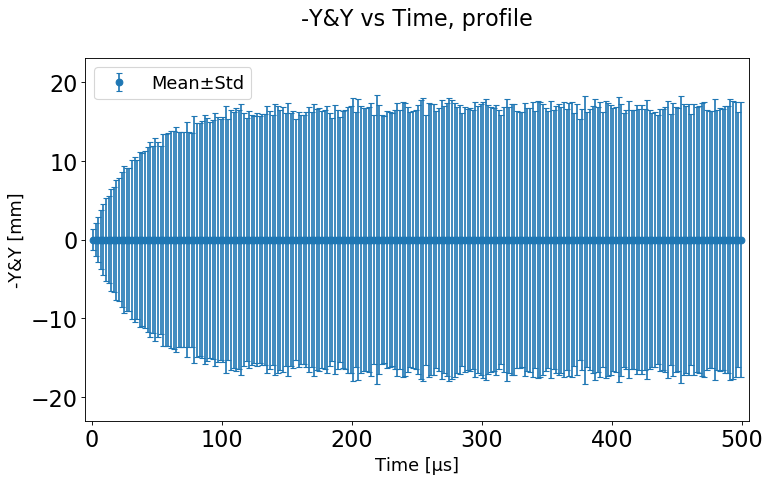

In [76]:
plt.errorbar(profile_Time, profile_mean, yerr=profile_std, fmt='o', capsize=3, label='Mean±Std')
plt.title('-Y&Y vs Time, profile' +'\n')
plt.xlabel('Time [μs]')
plt.ylabel('-Y&Y [mm]')
plt.xlim(-5,505)
plt.ylim(-23,23)

plt.legend()
plt.show()

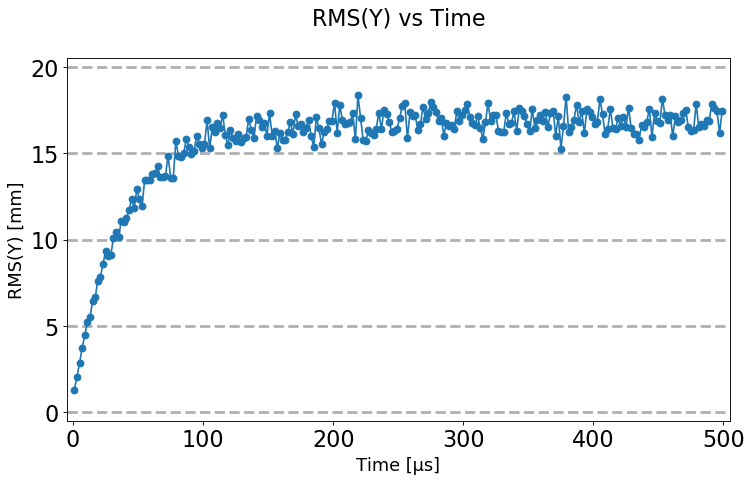

In [77]:
plt.plot(profile_Time,profile_std,'o-')

plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Y) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.show()

In [78]:
RMS_YvsT_top = [profile_Time,profile_std]

In [85]:
def Approach16(x, A, a):
    return A*(x**2)/(x**2+a)+1.5

params, covariance = curve_fit(Approach16, profile_Time, profile_std, p0=[16, 1])
A, a= params
print(A,a)

15.451870627840119 817.9051105819132


In [110]:
Approach16(100, A, a)

15.783607103121408

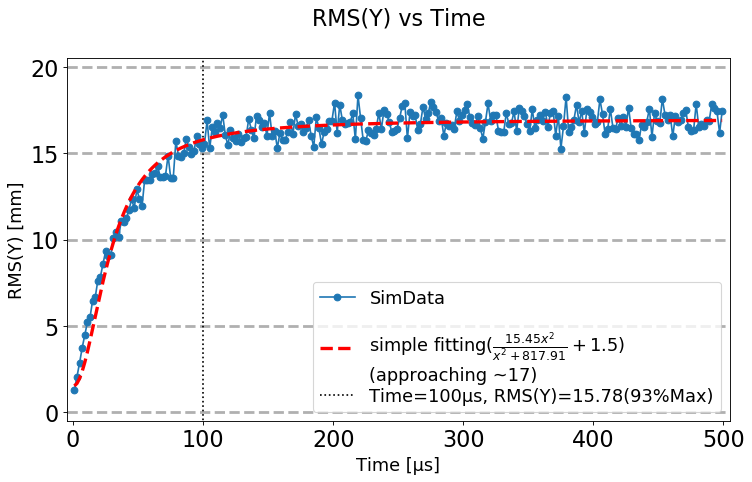

In [115]:
plt.plot(profile_Time,profile_std,'o-',label='SimData')
plt.plot(profile_Time,Approach16(profile_Time,A,a),'r--',linewidth=3,
         label='simple fitting'+r'($\frac{15.45x^2}{x^2+817.91}+1.5$)'+'\n(approaching ~17)')
plt.vlines(100,-1,21,colors='k',linestyles='dotted',label='Time=100μs, RMS(Y)=15.78(93%Max)')
plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Y) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

In [116]:
def Approach16(x, A, a):
    return A*(x**2)/(x**2+a)+1

params, covariance = curve_fit(Approach16, profile_Time, profile_std, p0=[16, 1])
A, a = params
print(A,a)

15.932917924633275 755.8443570758526


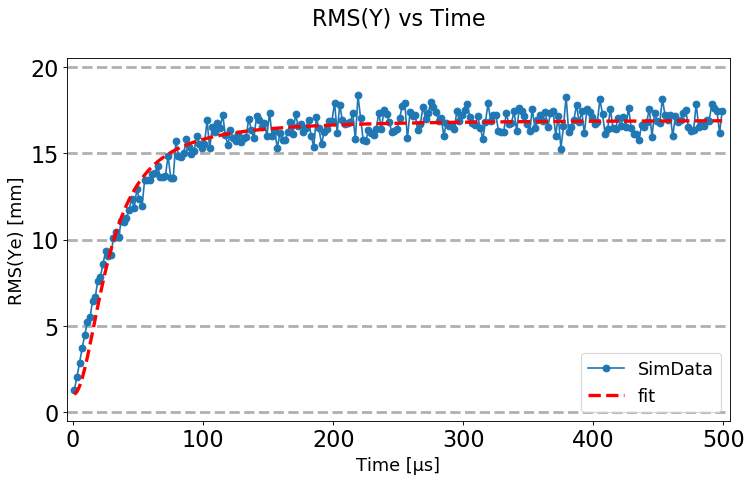

In [117]:
plt.plot(profile_Time,profile_std,'o-',label='SimData')
plt.plot(profile_Time,Approach16(profile_Time,A,a),'r--',linewidth=3,label='fit')

plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Ye) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

In [118]:
N = len(profile_Time)
Ecoll_top_per2us = np.zeros(N)
for i in range(N):
    timecut_l = Time3_top>(i*2)
    timecut_h = Time3_top<(i*2+2)
    Ecoll_top_per2us[i]=np.sum(Ecoll_top[timecut_l&timecut_h])

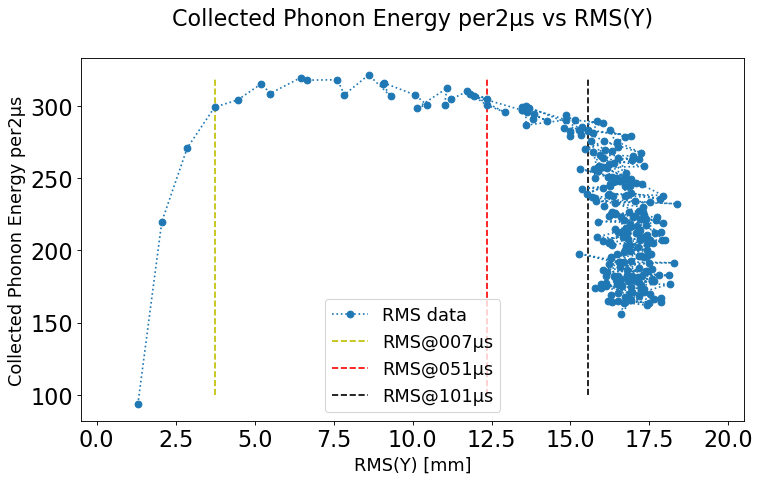

In [119]:
plt.plot(profile_std,Ecoll_top_per2us,'o:',label='RMS data')
plt.vlines(profile_std[3], 100,320,linestyles='dashed',colors='y', label='RMS@007μs')
plt.vlines(profile_std[25],100,320,linestyles='dashed',colors='r', label='RMS@051μs')
plt.vlines(profile_std[50],100,320,linestyles='dashed',colors='k', label='RMS@101μs')

plt.title('Collected Phonon Energy per2μs vs RMS(Y)'+'\n')
plt.xlabel('RMS(Y) [mm]')
plt.ylabel('Collected Phonon Energy per2μs')
#plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-0.5,20.5)
#plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

## 2.2 Bottom Surface

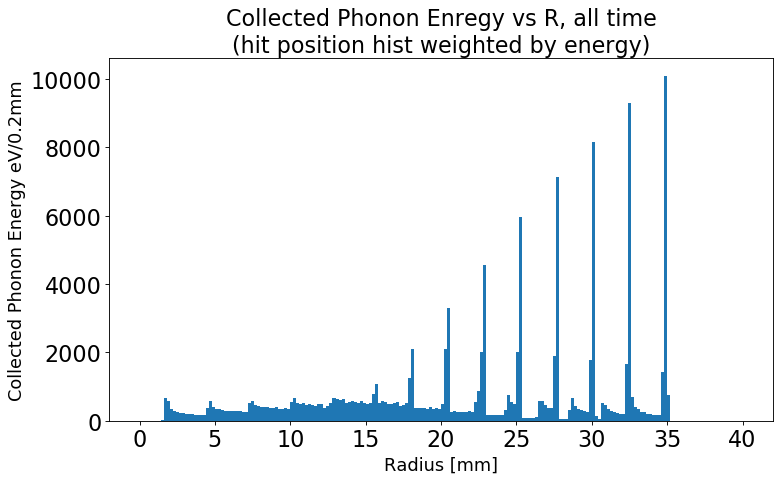

In [120]:
LHS    = 0.0
RHS    = 40
nbins  = 200
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(R3_bottom,weights=Ecoll_bottom,bins=setbins)

plt.title('Collected Phonon Enregy vs R, all time\n'+'(hit position hist weighted by energy)')
plt.xlabel('Radius [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

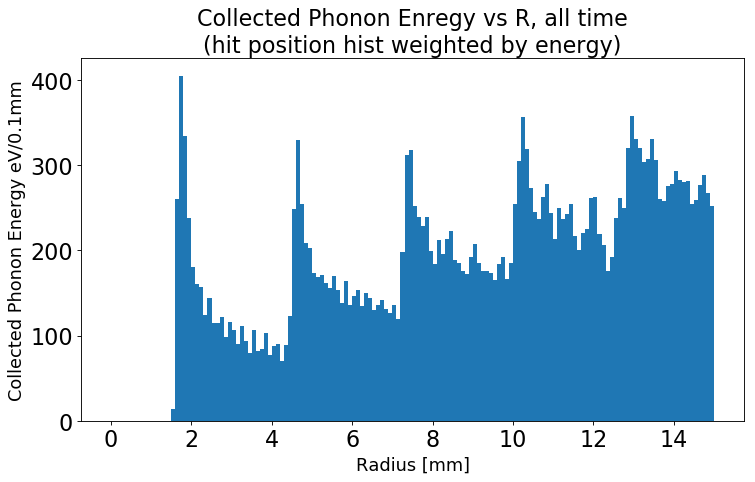

In [121]:
LHS    = 0.0
RHS    = 15
nbins  = 150
binlen = (RHS-LHS)/nbins
setbins=np.linspace(LHS,RHS,nbins+1)
plt.hist(R3_bottom,weights=Ecoll_bottom,bins=setbins)

plt.title('Collected Phonon Enregy vs R, all time\n'+'(hit position hist weighted by energy)')
plt.xlabel('Radius [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
#plt.ylim(5e-1,5e5)
plt.show()

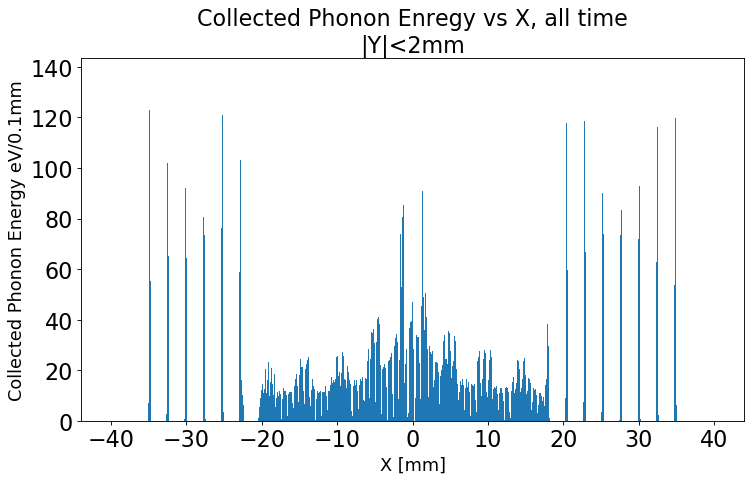

In [122]:
LHS    = -40.0
RHS    =  40.0
binlen =  0.1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
cutY = (np.abs(Y3_bottom)<2)
plt.hist(X3_bottom[cutY],weights=Ecoll_bottom[cutY],bins=setbins)

plt.title('Collected Phonon Enregy vs X, all time\n'+'|Y|<2mm')
plt.xlabel('X [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.show()
plt.show()

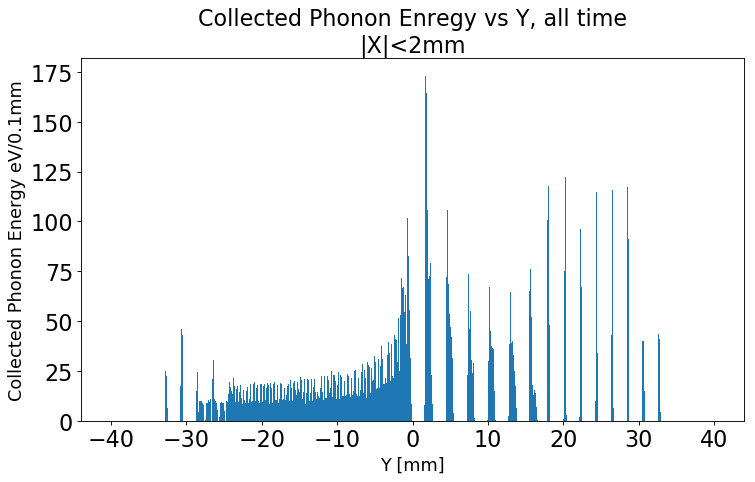

In [123]:
LHS    = -40.0
RHS    =  40.0
binlen =  0.1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
cutX = (np.abs(X3_bottom)<2)
plt.hist(Y3_bottom[cutX],weights=Ecoll_bottom[cutX],bins=setbins)

plt.title('Collected Phonon Enregy vs Y, all time\n'+'|X|<2mm')
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.show()
plt.show()

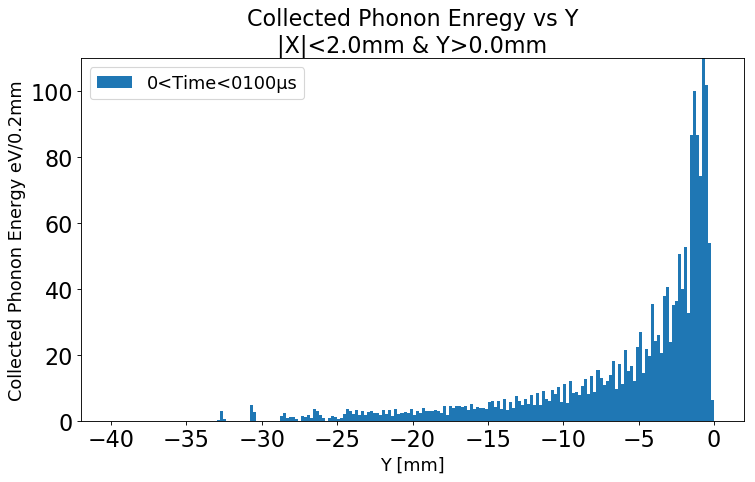

In [124]:
LHS    =  -40.0
RHS    =  0.0
binlen =  0.2
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXYT = (Y3_bottom<ylim)&(np.abs(X3_bottom)<xlim)&(Time3_bottom>tlim0)&(Time3_bottom<tlim1)
plt.hist(Y3_bottom[cutXYT],weights=Ecoll_bottom[cutXYT],bins=setbins,label='{}<Time<{:04d}μs'.format(tlim0,tlim1))

plt.title('Collected Phonon Enregy vs Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy eV/{:}mm'.format(binlen))
#plt.yscale('log')
plt.legend()
plt.ylim(0,1.1e2)
plt.show()

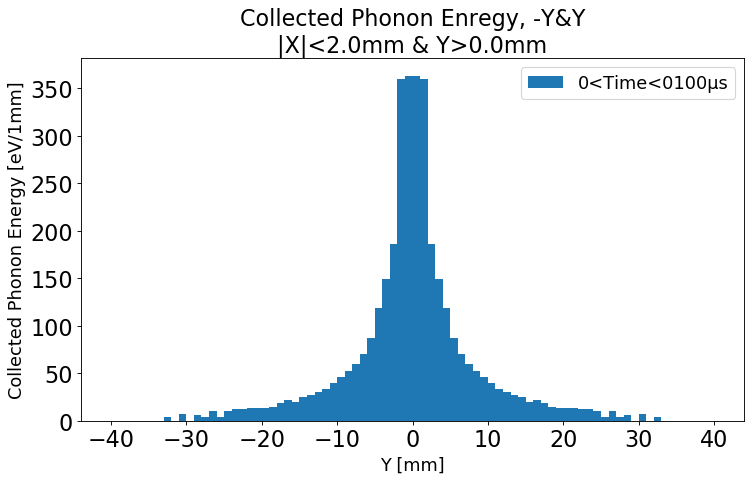

In [125]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXYT = (Y3_bottom<ylim)&(np.abs(X3_bottom)<xlim)&(Time3_bottom>tlim0)&(Time3_bottom<tlim1)
Y3_bottom_dual    = np.concatenate((-Y3_bottom[cutXYT],Y3_bottom[cutXYT]))
Ecoll_bottom_dual = np.concatenate((Ecoll_bottom[cutXYT],Ecoll_bottom[cutXYT]))
gaussdata = plt.hist(Y3_bottom_dual,weights=Ecoll_bottom_dual,bins=setbins,label='{}<Time<{:04d}μs'.format(tlim0,tlim1))

plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

In [126]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-1/2*(abs((x-mu)/sigma))**0.6)

In [127]:
y_data = gaussdata[0]
x_data = gaussdata[1][1:]-0.5

params, covariance = curve_fit(gaussian, x_data, y_data, p0=[1000, np.mean(x_data), np.std(x_data)])
A, mu, sigma = params
print(A,mu,sigma)

619.4975216310277 -3.950530810863596e-06 -0.6417914159490348


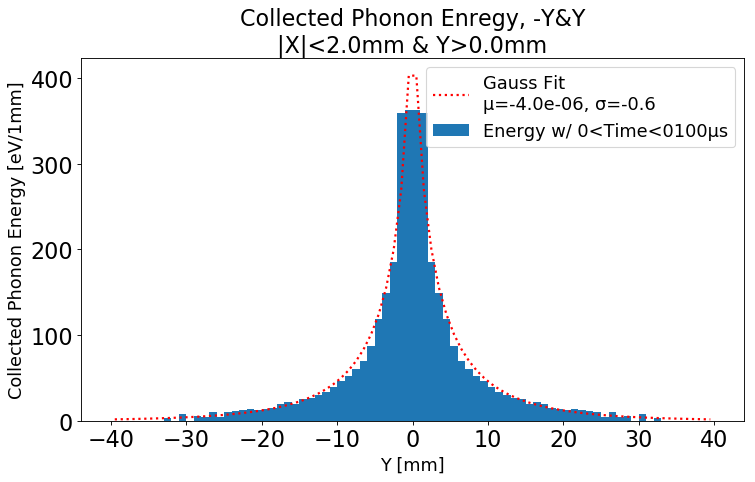

In [128]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 100
cutXYT = (Y3_bottom<ylim)&(np.abs(X3_bottom)<xlim)&(Time3_bottom>tlim0)&(Time3_bottom<tlim1)
Y3_bottom_dual    = np.concatenate((-Y3_bottom[cutXYT],Y3_bottom[cutXYT]))
Ecoll_bottom_dual = np.concatenate((Ecoll_bottom[cutXYT],Ecoll_bottom[cutXYT]))
plt.hist(Y3_bottom_dual,weights=Ecoll_bottom_dual,bins=setbins,label='Energy w/ {}<Time<{:04d}μs'.format(tlim0,tlim1))
fitlabel = 'Gauss Fit\nμ={:.1e}, σ={:.1f}'.format(mu, sigma)
plt.plot(x_data,gaussian(x_data,A,mu,sigma),'r:',linewidth=2,label=fitlabel)

plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

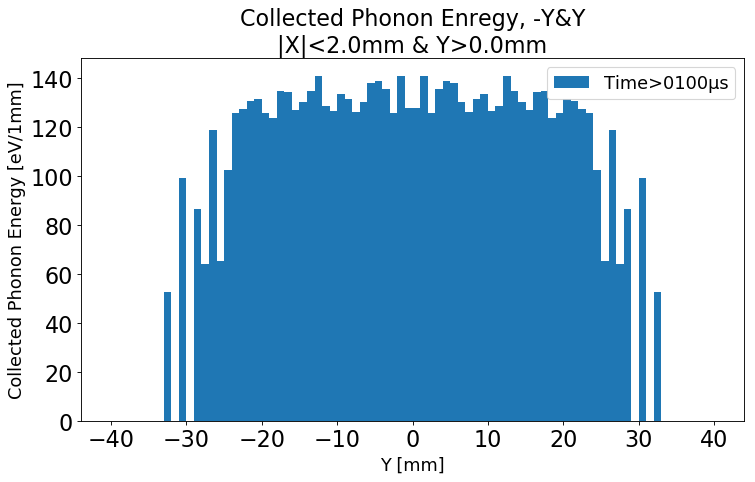

In [129]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 100
tlim1 = 1e5
cutXYT = (Y3_bottom<ylim)&(np.abs(X3_bottom)<xlim)&(Time3_bottom>tlim0)
Y3_bottom_dual    = np.concatenate((-Y3_bottom[cutXYT],Y3_bottom[cutXYT]))
Ecoll_bottom_dual = np.concatenate((Ecoll_bottom[cutXYT],Ecoll_bottom[cutXYT]))
plt.hist(Y3_bottom_dual,weights=Ecoll_bottom_dual,bins=setbins,label='Time>{:04d}μs'.format(tlim0))

plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

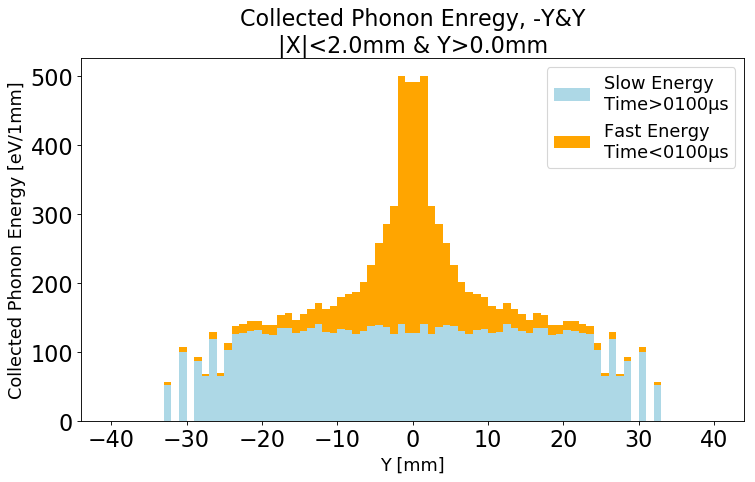

In [130]:
LHS    = -40.0
RHS    =  40.0
binlen =  1
nbins  = int((RHS-LHS)/binlen)
setbins=np.linspace(LHS,RHS,nbins+1)
xlim  = 2.
ylim  = 0.
tlim0 = 100
tlim1 = 1e5
cutXY = (Y3_bottom<ylim)&(np.abs(X3_bottom)<xlim)
cutTF = (Time3_bottom<tlim0)
cutTS = (Time3_bottom>tlim0)
Y3_bottom_dual_fast    = np.concatenate((  -Y3_bottom[cutXY&cutTF],   Y3_bottom[cutXY&cutTF]))
Ecoll_bottom_dual_fast = np.concatenate((Ecoll_bottom[cutXY&cutTF],Ecoll_bottom[cutXY&cutTF]))
Y3_bottom_dual_slow    = np.concatenate((  -Y3_bottom[cutXY&cutTS],   Y3_bottom[cutXY&cutTS]))
Ecoll_bottom_dual_slow = np.concatenate((Ecoll_bottom[cutXY&cutTS],Ecoll_bottom[cutXY&cutTS]))
Y3_bottom_2T = [Y3_bottom_dual_slow,Y3_bottom_dual_fast]
Ecoll_bottom_2T = [Ecoll_bottom_dual_slow,Ecoll_bottom_dual_fast]
labels_2T = ['Slow Energy\nTime>{:04d}μs'.format(tlim0),'Fast Energy\nTime<{:04d}μs'.format(tlim0)]
plt.hist(Y3_bottom_2T,weights=Ecoll_bottom_2T,bins=setbins,color=['lightblue','orange'],
         alpha=1,label=labels_2T,stacked=True)
#plt.hist(,weights=Ecoll_bottom_dual_fast,bins=setbins,
#         label='Time<{:04d}μs'.format(tlim0),cumulative='True')


plt.title('Collected Phonon Enregy, -Y&Y\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Y [mm]')
plt.ylabel('Collected Phonon Energy [eV/{:}mm]'.format(binlen))
#plt.yscale('log')
plt.legend()
#plt.ylim(0,1.3e5)
plt.show()

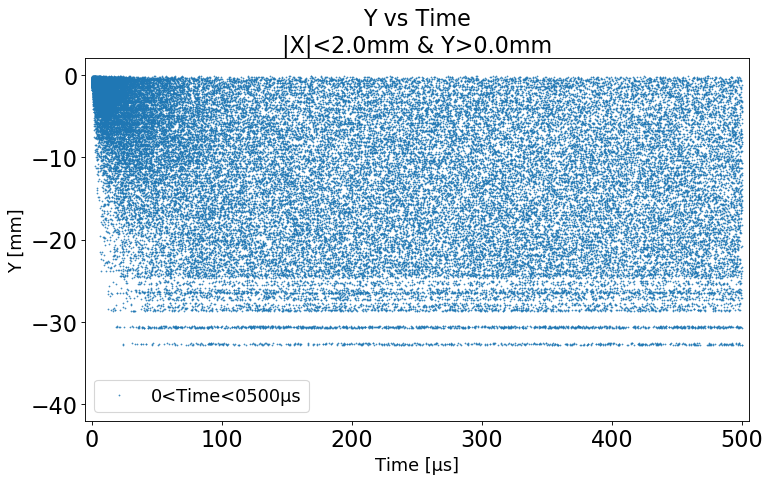

In [131]:
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 500
cutXYT = (Y3_bottom<ylim)&(np.abs(X3_bottom)<xlim)&(Time3_bottom>tlim0)&(Time3_bottom<tlim1)
plt.plot(Time3_bottom[cutXYT],Y3_bottom[cutXYT],'.', markersize=1, label='{}<Time<{:04d}μs'.format(tlim0,tlim1))
plt.title('Y vs Time\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Time [μs]')
plt.ylabel('Y [mm]'.format(binlen))
plt.ylim(-42,2)
plt.xlim(-5,505)
plt.legend()
plt.show()

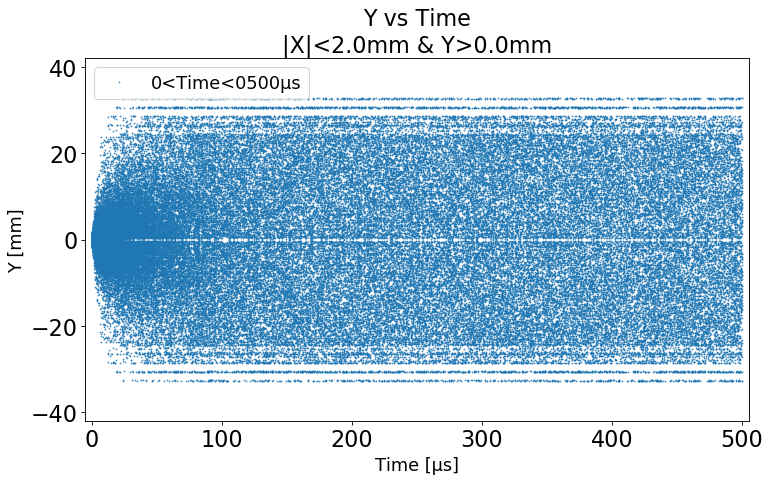

In [132]:
xlim  = 2.
ylim  = 0.
tlim0 = 0
tlim1 = 500
cutXYT = (Y3_bottom<ylim)&(np.abs(X3_bottom)<xlim)&(Time3_bottom>tlim0)&(Time3_bottom<tlim1)
Y3_bottom_dual = np.concatenate((-Y3_bottom[cutXYT],Y3_bottom[cutXYT]))
Time3_bottom_dual  = np.concatenate((Time3_bottom[cutXYT],  Time3_bottom[cutXYT]))
plt.plot(Time3_bottom_dual,Y3_bottom_dual,'.', markersize=1, label='{}<Time<{:04d}μs'.format(tlim0,tlim1))
plt.title('Y vs Time\n'+'|X|<{}mm & Y>{}mm'.format(xlim,ylim))
plt.xlabel('Time [μs]')
plt.ylabel('Y [mm]'.format(binlen))
plt.ylim(-42,42)
plt.xlim(-5,505)
plt.legend()
plt.show()

In [133]:
if 'YvsTime' in locals():
    del YvsTime 

#maxbin = 37
#minbin = 1
#binlen = 1
#binnum = int((maxbin-minbin)/binlen)
#a = TProfile('th1d', 'profile1', binnum, minbin, maxbin)
bins   = np.array([0,2.]+list(range(4,501,2)))
xbn    = len(bins)-1
YvsTime= TProfile('YvsTime','YvsTime',xbn,bins)

new_array = np.column_stack((Time3_bottom_dual, Y3_bottom_dual))
fill_profile(YvsTime,new_array)

profile_Time  = np.array([YvsTime.GetBinCenter(xbin) for xbin in range(1,xbn+1)])
profile_mean  = np.array([YvsTime.GetBinContent(xbin) for xbin in range(1,xbn+1)])
profile_error = np.array([YvsTime.GetBinError(xbin) for xbin in range(1,xbn+1)])
bin_entr      = np.array([YvsTime.GetBinEntries(xbin) for xbin in range(1,xbn+1)])
profile_std   = np.sqrt(bin_entr)*profile_error # std of mean -> std of the data

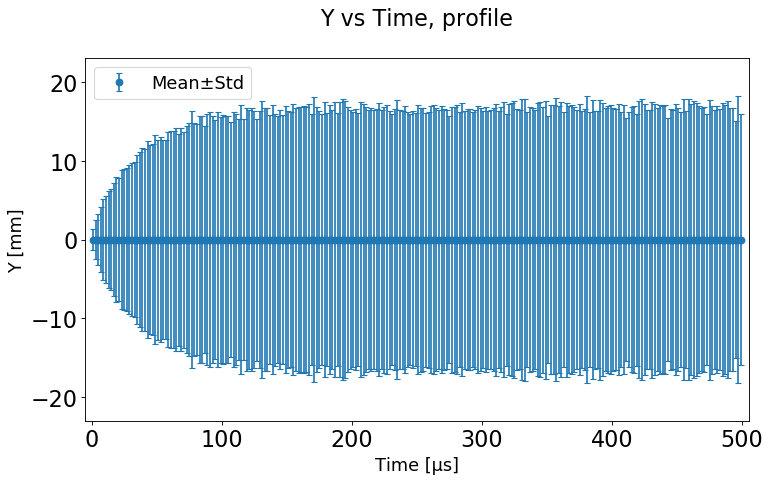

In [134]:
plt.errorbar(profile_Time, profile_mean, yerr=profile_std, fmt='o', capsize=3, label='Mean±Std')
plt.title('Y vs Time, profile' +'\n')
plt.xlabel('Time [μs]')
plt.ylabel('Y [mm]')
plt.xlim(-5,505)
plt.ylim(-23,23)

plt.legend()
plt.show()

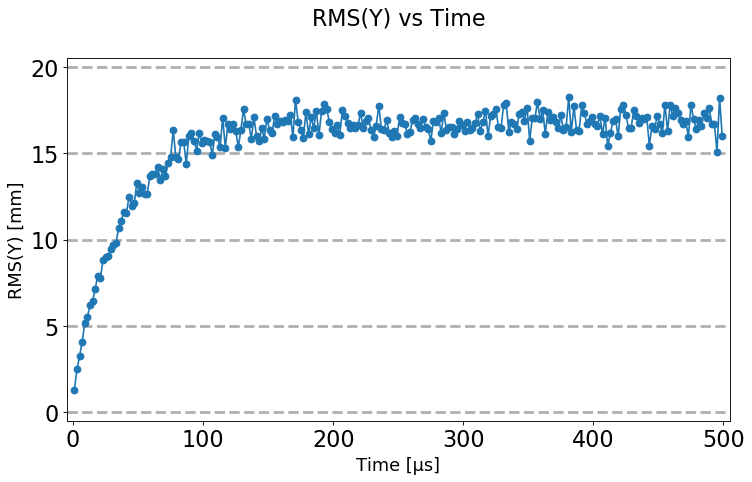

In [135]:
plt.plot(profile_Time,profile_std,'o-')

plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Y) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.show()

In [136]:
RMS_YvsT_bottom = [profile_Time,profile_std]

In [137]:
def Approach16(x, A, a, b):
    return A*(x**2)/(x**2+a)+b

params, covariance = curve_fit(Approach16, profile_Time, profile_std, p0=[16, 1,1])
A, a, b= params
print(A,a,b)

13.59145379181505 1024.3911007406184 3.379506222583424


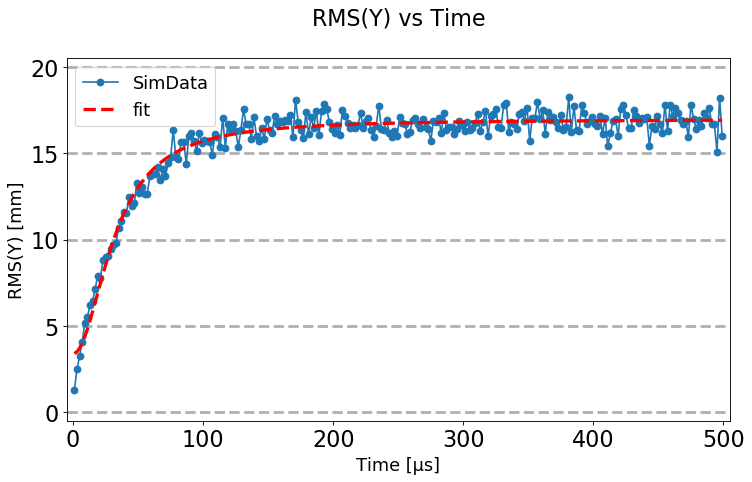

In [138]:
plt.plot(profile_Time,profile_std,'o-',label='SimData')
plt.plot(profile_Time,Approach16(profile_Time,A,a,b),'r--',linewidth=3,label='fit')

plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Y) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

In [139]:
def Approach16(x, A, a):
    return A*(x**2)/(x**2+a)+1

params, covariance = curve_fit(Approach16, profile_Time, profile_std, p0=[16, 1])
A, a = params
print(A,a)

15.885852462038885 697.3490594041983


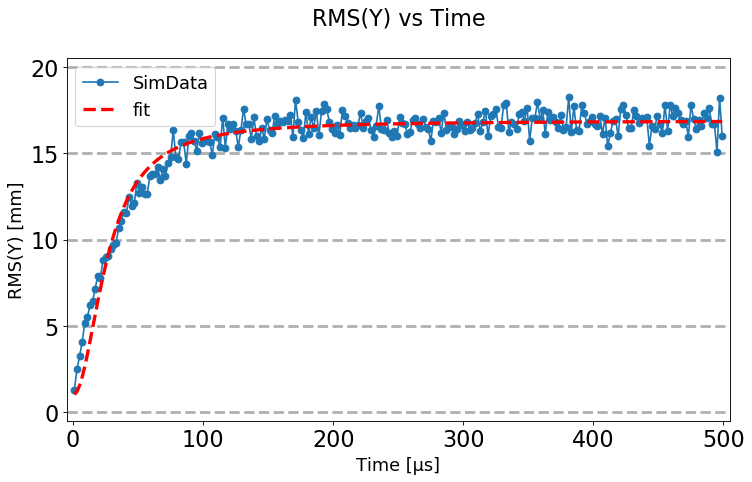

In [140]:
plt.plot(profile_Time,profile_std,'o-',label='SimData')
plt.plot(profile_Time,Approach16(profile_Time,A,a),'r--',linewidth=3,label='fit')

plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Y) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

In [141]:
N = len(profile_Time)
Ecoll_bottom_per2us = np.zeros(N)
for i in range(N):
    timecut_l = Time3_bottom>(i*2)
    timecut_h = Time3_bottom<(i*2+2)
    Ecoll_bottom_per2us[i]=np.sum(Ecoll_bottom[timecut_l&timecut_h])

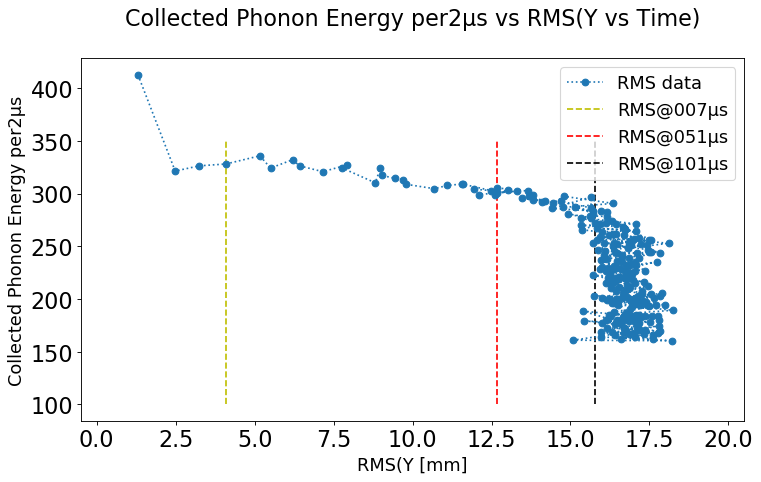

In [142]:
plt.plot(profile_std,Ecoll_bottom_per2us,'o:',label='RMS data')
plt.vlines(profile_std[3], 100,350,linestyles='dashed',colors='y', label='RMS@007μs')
plt.vlines(profile_std[25],100,350,linestyles='dashed',colors='r', label='RMS@051μs')
plt.vlines(profile_std[50],100,350,linestyles='dashed',colors='k', label='RMS@101μs')

plt.title('Collected Phonon Energy per2μs vs RMS(Y vs Time)'+'\n')
plt.xlabel('RMS(Y [mm]')
plt.ylabel('Collected Phonon Energy per2μs')
#plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-0.5,20.5)
#plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

## 2.3Top vs Bottom

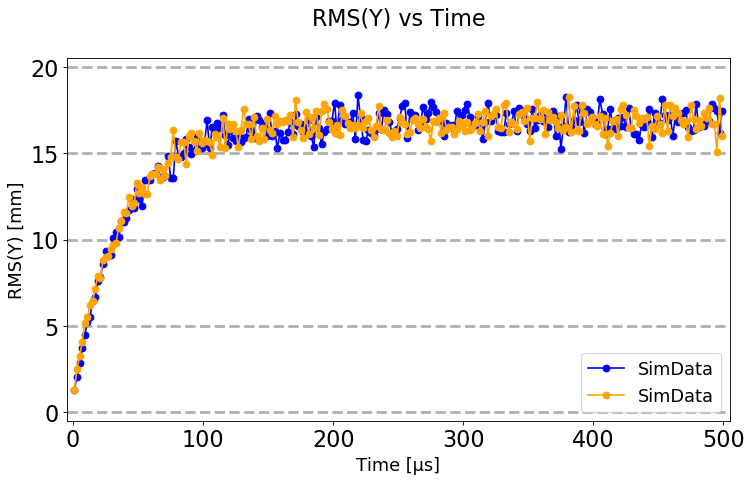

In [143]:
plt.plot(RMS_YvsT_top[0],   RMS_YvsT_top[1],   'o-',label='SimData',color='blue')
plt.plot(RMS_YvsT_bottom[0],RMS_YvsT_bottom[1],'o-',label='SimData',color='orange')

plt.title('RMS(Y) vs Time'+'\n')
plt.xlabel('Time [μs]')
plt.ylabel('RMS(Y) [mm]')
plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-5,505)
plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

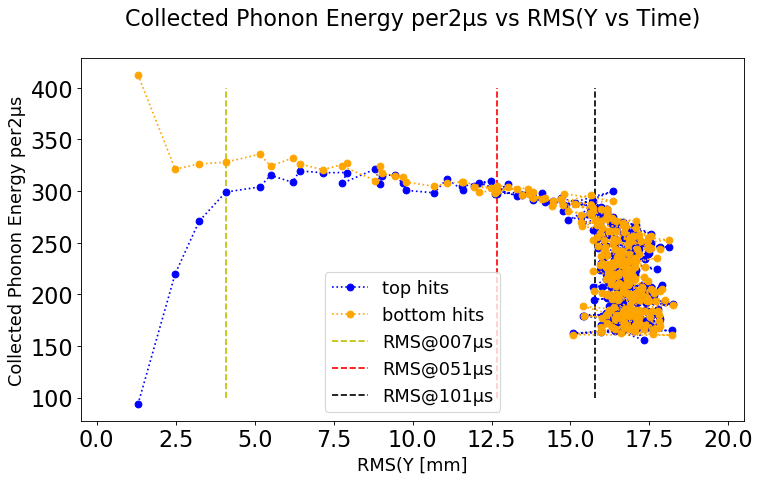

In [100]:
plt.plot(profile_std,Ecoll_top_per2us,   'o:',label='top hits',   color='blue')
plt.plot(profile_std,Ecoll_bottom_per2us,'o:',label='bottom hits',color='orange')
plt.vlines(profile_std[3], 100,400,linestyles='dashed',colors='y', label='RMS@007μs')
plt.vlines(profile_std[25],100,400,linestyles='dashed',colors='r', label='RMS@051μs')
plt.vlines(profile_std[50],100,400,linestyles='dashed',colors='k', label='RMS@101μs')

plt.title('Collected Phonon Energy per2μs vs RMS(Y vs Time)'+'\n')
plt.xlabel('RMS(Y [mm]')
plt.ylabel('Collected Phonon Energy per2μs')
#plt.grid(axis='y',ls='--',lw=2.5)
plt.xlim(-0.5,20.5)
#plt.ylim(-0.5,20.5)
plt.legend()
plt.show()

In [9]:
Eloss_bybin = np.zeros(nbin+1000)

In [17]:
%time
for i in tqdm(range(nbin)): 
    timeslice = (Time3>=Tbin*i)&(Time3<Tbin*(i+1))
    Eloss_bybin[i+1000] = np.sum(Eloss[timeslice])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


100%|██████████| 14500/14500 [04:07<00:00, 58.47it/s]


In [21]:
b = 6000
Eloss_bybin[b:b+100]

array([0.00439786, 0.00307907, 0.00492717, 0.00317379, 0.00411607,
       0.00359328, 0.00322352, 0.00266793, 0.00362404, 0.00453164,
       0.00560115, 0.00312789, 0.00433098, 0.00311281, 0.0049424 ,
       0.00285015, 0.00505737, 0.00368055, 0.00339295, 0.00416309,
       0.00439313, 0.00416603, 0.00362595, 0.00366471, 0.00246201,
       0.0053033 , 0.00386202, 0.00302295, 0.00435523, 0.00470634,
       0.00398261, 0.00483428, 0.00295509, 0.00246777, 0.0035568 ,
       0.00324081, 0.00408325, 0.00468223, 0.00441629, 0.00433884,
       0.00415092, 0.00289539, 0.00473759, 0.00313844, 0.0025346 ,
       0.00182279, 0.00446597, 0.00478546, 0.0048639 , 0.00305384,
       0.00311713, 0.00363108, 0.00387686, 0.00328806, 0.00360547,
       0.00445767, 0.00297781, 0.00386208, 0.00413601, 0.00354885,
       0.00458547, 0.00377128, 0.00327859, 0.0043137 , 0.00353897,
       0.0049322 , 0.00324717, 0.00404589, 0.00451882, 0.00606534,
       0.00413596, 0.0018906 , 0.00445745, 0.00333443, 0.00450